In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
% matplotlib inline
import seaborn as sb
import mpld3 # interactive plots

In [2]:
random_seed = 42

## Utility function to drop duplicate columns

In [3]:
from pandas.core.common import array_equivalent

def remove_duplicate_cols(df):
    """http://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
    
    Use like:
    df = remove_duplicate_cols(df)
    
    If no duplicates, we return gracefully
    """
    Cols = list(df.columns)
    for i,item in enumerate(df.columns):
        if item in df.columns[:i]: Cols[i] = "toDROP"
    df.columns = Cols
    drop_cols = len([col for col in list(df.columns) if col == 'toDROP'])
    if drop_cols:
        return df.drop("toDROP", axis=1)
    else:
        return df

In [4]:
ls data/turn_data

dal_turns_dev.csv     is13_turns_train.csv  neo_turns_test.csv
dal_turns_test.csv    liwc_turns_dev.csv    neo_turns_train.csv
dal_turns_train.csv   liwc_turns_test.csv   turns_dev.csv
is13_turns_dev.csv    liwc_turns_train.csv  turns_test.csv
is13_turns_test.csv   neo_turns_dev.csv     turns_train.csv


## Read in and Format the data

In [5]:
dal = {'train':pd.read_csv('data/turn_data/dal_turns_train.csv'),
       'dev':pd.read_csv('data/turn_data/dal_turns_dev.csv'),
       'test':pd.read_csv('data/turn_data/dal_turns_test.csv')}
dal['train'].head(1)

/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


turn                  name  FunctionalWordPercent  mean_pleaseant  \
0     0  p204p205-part1_ch1_1               0.520152        0.308089   

   max_pleaseant  min_pleaseant  median_pleaseant  std_pleaseant  \
0       0.183774        0.48641          0.258734       0.551203   

   var_pleaseant  mean_activate ...   std_activate  var_activate  \
0       0.422819       0.381126 ...       0.709322      0.681551   

   mean_imagery  max_imagery  min_imagery  median_imagery  std_imagery  \
0      0.973491      0.86647     0.136192        1.105293     1.114331   

   var_imagery  label  pid  
0     1.313934      0  205  

[1 rows x 23 columns]

In [6]:
# is13 = {'train':pd.read_csv('data/turn_data/is13_turns_train.csv'),
#        'dev':pd.read_csv('data/turn_data/is13_turns_dev.csv'),
#        'test':pd.read_csv('data/turn_data/is13_turns_test.csv')}

In [7]:
liwc = {'train':pd.read_csv('data/turn_data/liwc_turns_train.csv'),
       'dev':pd.read_csv('data/turn_data/liwc_turns_dev.csv'),
       'test':pd.read_csv('data/turn_data/liwc_turns_test.csv')}

In [8]:
neo = {'train':pd.read_csv('data/turn_data/neo_turns_train.csv'),
       'dev':pd.read_csv('data/turn_data/neo_turns_dev.csv'),
       'test':pd.read_csv('data/turn_data/neo_turns_test.csv')}

In [9]:
turn = {'train':pd.read_csv('data/turn_data/turns_train.csv'),
       'dev':pd.read_csv('data/turn_data/turns_dev.csv'),
       'test':pd.read_csv('data/turn_data/turns_test.csv')}

In [10]:
turn['train'].shape, dal['train'].shape, liwc['train'].shape, neo['train'].shape

((4216, 7), (4216, 23), (4216, 134), (4216, 9))

In [11]:
# combine all the data
all_train = pd.concat([turn['train'], neo['train'], liwc['train'], dal['train']], axis=1)
all_dev = pd.concat([turn['dev'], neo['dev'], liwc['dev'], dal['dev']], axis=1)
all_test = pd.concat([turn['test'], neo['test'], liwc['test'], dal['test']], axis=1)

# all_train = pd.concat([turn['train'], neo['train'], liwc['train'], dal['train']], axis=1)
# all_dev = pd.concat([turn['dev'], neo['dev'], liwc['dev'], dal['dev']], axis=1)
# all_test = pd.concat([turn['test'], neo['test'], liwc['test'], dal['test']], axis=1)

# drop columns duplicated across feature sets
all_train = remove_duplicate_cols(all_train)
all_dev = remove_duplicate_cols(all_dev)
all_test = remove_duplicate_cols(all_test)

# index by person by ipu
all_train = all_train.set_index(['pid', 'turn'])
all_dev = all_dev.set_index(['pid', 'turn'])
all_test = all_test.set_index(['pid', 'turn'])

# drop columns that aren't covariates or labels
useless_cols = ['Unnamed: 0', 'fname', 'name', 'start', 'end']
all_train = all_train.drop(useless_cols, axis=1)
all_dev = all_dev.drop(useless_cols, axis=1)
all_test = all_test.drop(useless_cols, axis=1)

In [12]:
all_train.shape, all_dev.shape, all_test.shape

((4216, 158), (3030, 158), (4427, 158))

In [13]:
# combine the training and dev datasets
all_train = pd.concat([all_train, all_dev])

In [14]:
# fill in the random NaNs with 0, since working with standardized columns
all_train = all_train.fillna(0.0)
all_dev = all_dev.fillna(0.0)
all_test = all_test.fillna(0.0)

In [15]:
all_train.isnull().any().any()

False

In [16]:
all_test.isnull().any().any()

False

In [17]:
# ### WRITE OUT FINAL CSVS ###
# all_train.to_csv('data/final_turns_train.csv')
# all_test.to_csv('data/final_turns_test.csv')

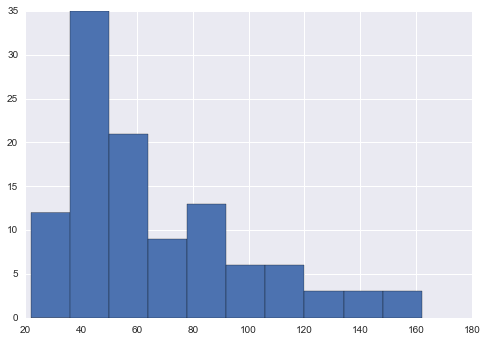

In [18]:
# number of ipus by pid
all_train.groupby(level=0).count()['text'].hist()

In [19]:
# label baselines for train and test
t, f = all_train['label'].value_counts()
train_base = max([t,f])/float(sum([t,f]))
print "Training baseline: %2.4f" % train_base

t, f = all_test['label'].value_counts()
test_base = max([t,f])/float(sum([t,f]))
print "Test baseline: %2.4f" % test_base

class_names = ['Not Deceptive', 'Deceptive'] # 0 is truth, 1 is lie

Training baseline: 0.6110
Test baseline: 0.6052


In [20]:
all_train.head(1)

text  label  Gender  Language  \
pid turn                                                                 
205 0     i i was born in in the dalian city       0     0.0       1.0   

          Nscore_raw  Escore_raw  Oscore_raw  Ascore_raw  Cscore_raw  \
pid turn                                                               
205 0       0.836309   -1.427222   -0.880482   -0.267426   -1.479525   

          LIWC_funct_funcword     ...       min_activate  median_activate  \
pid turn                          ...                                       
205 0                0.963346     ...           0.100502         0.302449   

          std_activate  var_activate  mean_imagery  max_imagery  min_imagery  \
pid turn                                                                       
205 0         0.709322      0.681551      0.973491      0.86647     0.136192   

          median_imagery  std_imagery  var_imagery  
pid turn                                            
205 0           1.105293     1.114331     1.313934  

[1 rows x 158 columns]

In [21]:
noncovariates = ['label', 'text']
train_x = all_train.drop(noncovariates, axis=1).as_matrix()
train_y = all_train['label'].as_matrix()
test_x = all_test.drop(noncovariates, axis=1).as_matrix()
test_y = all_test['label'].as_matrix()

feature_labels = list(all_train.drop(noncovariates, axis=1).columns.values)
print train_x.shape, test_x.shape

(7246, 156) (4427, 156)


In [22]:
np.any(np.isnan(train_x)), np.any(np.isnan(train_y))

(False, False)

In [23]:
np.any(np.isnan(test_x)), np.any(np.isnan(test_y))

(False, False)

In [24]:
def experiment(clf, param_grid, grid_metric='accuracy',
               train_x=train_x, train_y=train_y, 
               test_x=test_x, test_y=test_y, 
               label_names=class_names, cv=10):
    """Run GridSearchCv on the pipeline `clf` with `cv` number of folds over `grid`
    
    Then refit the best parameters on all of the train data, and analyze the test performance
    
    Performance metrics: accuracy, f1-score for Deceptive, confusion matrix
    
    NOTE: Specify parallel jobs in clf.  Won't do grid search in parallel.
    """
    print "Searching Grid..."
    grid = GridSearchCV(clf, param_grid, grid_metric, cv=cv, verbose=1)
    grid.fit(train_x, train_y)
    print "Fitting best estimator..."
    print "Chosen parameters: \n", grid.best_params_
    print "Best Estimator: \n", grid.best_estimator_
    clf.set_params(**grid.best_params_)
    clf.fit(train_x, train_y)
    print "Evaluating on Test..."
    preds = clf.predict(test_x)
    acc = accuracy_score(test_y, preds)
    p = precision_score(test_y, preds)
    r = recall_score(test_y, preds)
    f1 = f1_score(test_y, preds)
    print "Test Accuracy: %1.4f, Test F1: %1.4f (P:%0.2f R:%0.2f)" % (acc, f1, p, r)
    confusion_matrix = cm(test_y, preds)
    results = {'clf': clf,
               'best_params':grid.best_params_,
               'grid_scores':grid.grid_scores_,
               'acc':acc,
               'f1':f1, 'precision':p, 'recall':r,
               'cm':confusion_matrix}
    return results

def plot_confusion_matrix(cm, label_names=class_names, save_name=None, 
                          title='Normed Confusion matrix', 
                          cmap=plt.cm.Blues, 
                          stats=None):
    """Take confusion matrix, label names and plot a very nice looking confusion matrix
    Args:
        cm: a confustion matrix w/ prediction rows and true columns
        label_names: list of class names for tick labels
        save_name (optional): if provided, save the figure to this location
        title (optional): the desired title
        cmap (optional): the colormap to display cell magnitudes with
        stats (optional): if stats, label class precisions and macro stats
    """
    fig, ax = plt.subplots(figsize=(6,6))
    
    # calc normalized cm
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0.0
    
    # print nonzero raw counts
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        norm = cm_normalized[x_val, y_val]
        c = "%i" % (cm.astype('int')[x_val, y_val])
        if norm > 0.0:
            color = 'white' if norm > .5 else 'black'
            ax.text(y_val, x_val, c, va='center', ha='center', color=color, fontsize=14)
    
    # actual plot
    im = ax.imshow(cm_normalized, interpolation='nearest', origin='upper', cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # set ticks and offset grid
    tick_marks = np.arange(len(label_names))
    tick_marks_offset = np.arange(len(label_names)) - .5
    ax.set_xticks(tick_marks, minor=False)
    ax.set_yticks(tick_marks, minor=False)
    ax.set_xticks(tick_marks_offset, minor=True)
    ax.set_yticks(tick_marks_offset, minor=True)
    ax.grid(which='minor')
    if stats:
        # include micro precisio, recall, and f1
        aug_y_labels = []
        for i in range(len(label_names)):
            aug = ("%s\nP:%0.2f, R:%0.2f, F1:%0.2f" 
                   % (label_names[i],
                      stats['class_precision'][i],
                      stats['class_recall'][i],
                      stats['class_f1'][i],))
            aug_y_labels.append(aug)
    else:
        aug_y_labels = label_names
    ax.set_xticklabels(label_names, horizontalalignment='left')
    ax.set_yticklabels(aug_y_labels)
    
    # other stuff
    plt.tight_layout()
    plt.ylabel('Predicted Labels', fontsize=16)
    if stats:
        # include macro 
        aug_x_label = ("True Labels\n Micro P:%0.2f, R:%0.2f, F1:%0.2f\n Macro P:%0.2f, R:%0.2f, F1:%0.2f" 
                       % (stats['micro_precision'], stats['micro_recall'], stats['micro_f1'],
                          stats['macro_precision'], stats['macro_recall'], stats['macro_f1']))
    else:
        aug_x_label = "True Label"
    plt.xlabel(aug_x_label, fontsize=16)
    plt.title(title, fontsize=18)
    if save_name:
        plt.savefig(save_name+'.pdf')
        
def plot_grid_scores(grid_scores, baseline=train_base):
    """Take grid scores and plot interactive box and whisker plot with baseline reference"""
    # determine endpoint of baseline
    cv_scores = [s[2] for s in grid_scores] # 2 is cross val scores
    labels = ["\n".join([str(val) for val in s[0].values()]) for s in grid_scores]
    x_label = ", ".join([str(key) for key in grid_scores[0][0].keys()])
    fig, ax = plt.subplots(figsize=(15,6))
    boxes = ax.boxplot(cv_scores)
    ax.hlines([baseline], [0], [len(grid_scores) + 1], linestyles='dashed', label='Baseline Accuracy')
    
    plt.legend(loc='best')
    ax.set_title("Cross Validation Scores")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel(x_label)
    ax.set_xticklabels(labels, fontsize=8)
    plt.show()

In [25]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report as report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix as cm

# Random Forest w/o pre-feature selection

In [26]:
from sklearn.ensemble import RandomForestClassifier as RF

rf = RF(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid =dict(n_estimators=[10,100,200],#[5, 10, 50, 100, 200, 300], 
                 criterion=['entropy'],
                 max_features=[10, 'log2'],#, 'sqrt']
#                  max_depth=None, 
#                  min_samples_split=2, 
#                  min_samples_leaf=1, 
#                  min_weight_fraction_leaf=0.0, 
#                  max_features=['auto', 10], 
#                  max_leaf_nodes=None, 
#                  bootstrap=True, 
#                  oob_score=False, 
#                  n_jobs=1, 
#                  random_state=None, 
#                  verbose=0, 
#                  warm_start=False, 
#                  class_weight=None
                )
rf_results = experiment(rf, param_grid, cv=5)


Searching Grid...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   39.8s finished


Fitting best estimator...
Chosen parameters: 
{'max_features': 'log2', 'n_estimators': 200, 'criterion': 'entropy'}
Best Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Evaluating on Test...
Test Accuracy: 0.6088, Test F1: 0.1729 (P:0.52 R:0.10)


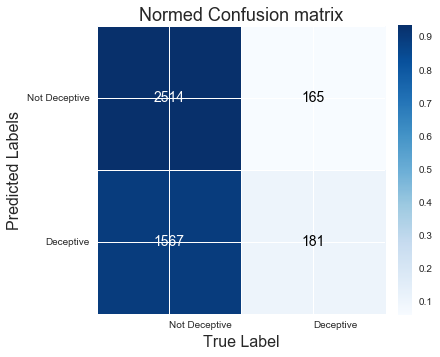

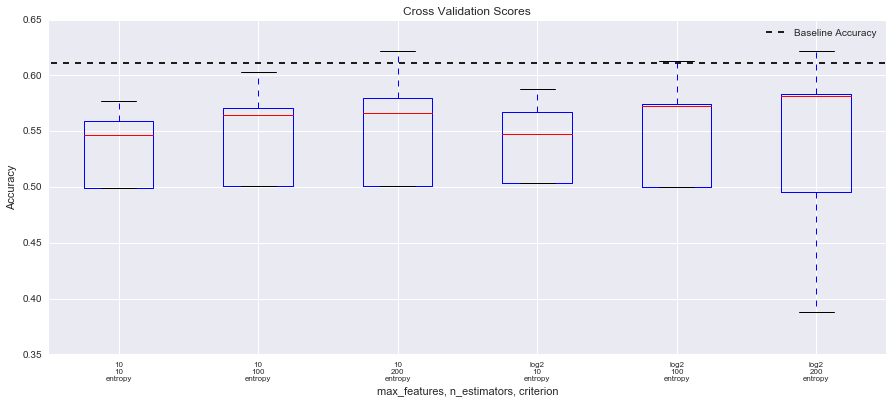

In [27]:
plot_confusion_matrix(rf_results['cm'])
plot_grid_scores(rf_results['grid_scores'])

In [53]:
imports = sorted(zip(feature_labels, rf_results['clf'].feature_importances_), key=lambda x:x[1], reverse=True)
for l, f in imports[:100]:
    print "%2.4f : %s" % (f,l)

0.0003 : LIWC_past_funcword
0.0003 : pcm_Mag_spectralRollOff25.0_sma_minRangeRel
0.0003 : audSpec_Rfilt_sma_de[6]_lpc1
0.0003 : LIWC_shehe
0.0003 : audSpec_Rfilt_sma[17]_lpc2
0.0003 : audSpec_Rfilt_sma[23]_maxPos
0.0003 : pcm_Mag_spectralRollOff90.0_sma_de_lpc2
0.0003 : mfcc_sma[4]_peakMeanRel
0.0003 : mfcc_sma[14]_linregerrQ
0.0003 : mfcc_sma[2]_linregerrQ
0.0003 : audSpec_Rfilt_sma[17]_lpc0
0.0003 : mfcc_sma_de[12]_risetime
0.0003 : mfcc_sma_de[12]_peakMeanRel
0.0003 : pcm_Mag_spectralEntropy_sma_de_upleveltime90
0.0003 : mfcc_sma_de[6]_upleveltime25
0.0003 : audSpec_Rfilt_sma[0]_lpc1
0.0003 : mfcc_sma[13]_lpc4
0.0003 : audSpec_Rfilt_sma_de[10]_maxSegLen
0.0003 : pcm_Mag_fband250-650_sma_percentile1.0
0.0003 : mfcc_sma[8]_peakMeanRel
0.0003 : mfcc_sma[13]_stddevRisingSlope
0.0002 : pcm_Mag_spectralRollOff90.0_sma_stddev
0.0002 : pcm_Mag_spectralSkewness_sma_upleveltime50
0.0002 : pcm_zcr_sma_percentile1.0
0.0002 : audSpec_Rfilt_sma[22]_lpc3
0.0002 : mfcc_sma[11]_linregc1
0.0002 : pcm

## Kernel SVM

In [27]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state=random_seed, verbose=5, loss='hinge')
param_grid = dict(C=np.logspace(-4,1,6), 
#                   kernel=['linear'], 
#                   degree=3, 
#                   gamma='auto', 
#                   coef0=0.0, 
#                   shrinking=True, 
#                   probability=False, 
#                   tol=0.001, 
#                   cache_size=200, 
#                   class_weight=None, 
#                   verbose=False, 
#                   max_iter=-1, 
#                   decision_function_shape=None, 
#                   random_state=random_seed
                 )
svm_results = experiment(svm, param_grid, cv=5)


Searching Grid...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/svm/base.py:924: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   28.3s finished


[LibLinear]Fitting best estimator...
Chosen parameters: 
{'C': 0.10000000000000001}
Best Estimator: 
LinearSVC(C=0.10000000000000001, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=5)
[LibLinear]Evaluating on Test...
Test Accuracy: 0.6052, Test F1: 0.0000 (P:0.00 R:0.00)


/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/thomaseffland/.virtualenvs/deceptive-speech/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


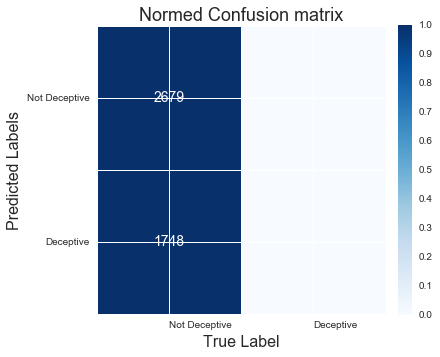

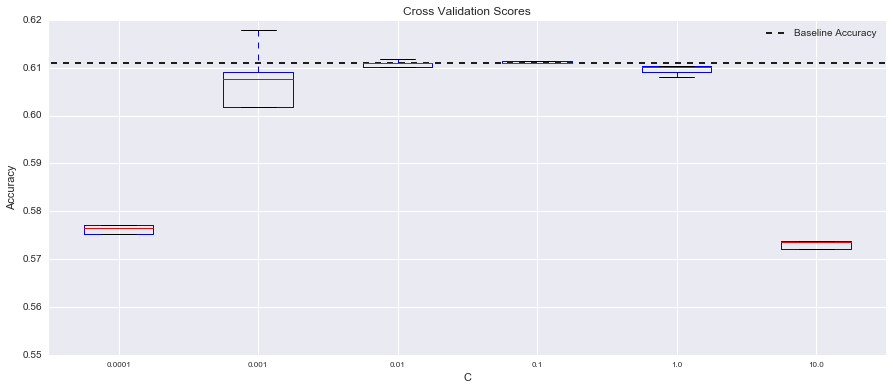

In [28]:
plot_confusion_matrix(svm_results['cm'])
plot_grid_scores(svm_results['grid_scores'])

In [30]:
from sklearn.svm import SVC

svm = SVC(random_state=random_seed)
param_grid = dict(C=np.logspace(-4,4,9), 
                  kernel=['rbf'], 
#                   degree=3, 
#                   gamma='auto', 
#                   coef0=0.0, 
#                   shrinking=True, 
#                   probability=False, 
#                   tol=0.001, 
#                   cache_size=200, 
#                   class_weight=None, 
#                   verbose=False, 
#                   max_iter=-1, 
#                   decision_function_shape=None, 
#                   random_state=random_seed
                 )
svm_results = experiment(svm, param_grid, cv=5)


Searching Grid...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  7.0min finished


Fitting best estimator...
Chosen parameters: 
{'kernel': 'rbf', 'C': 0.0001}
Best Estimator: 
SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
Evaluating on Test...
Test Accuracy: 0.6052, Test F1: 0.0000 (P:0.00 R:0.00)


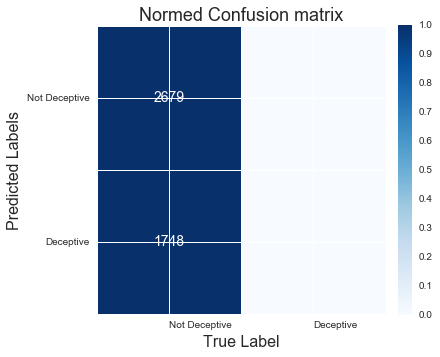

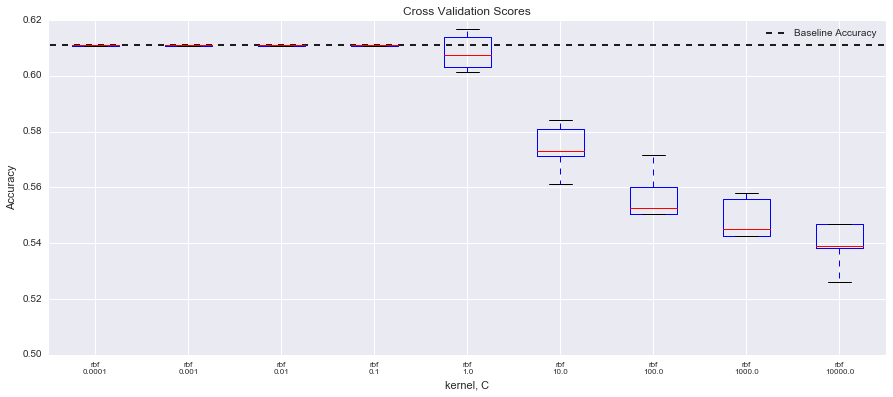

In [31]:
plot_confusion_matrix(svm_results['cm'])
plot_grid_scores(svm_results['grid_scores'])

In [32]:
from sklearn.svm import SVC

svm = SVC(random_state=random_seed)
param_grid = dict(C=np.logspace(-4,4,9), 
                  kernel=['poly'], 
#                   degree=3, 
#                   gamma='auto', 
#                   coef0=0.0, 
#                   shrinking=True, 
#                   probability=False, 
#                   tol=0.001, 
#                   cache_size=200, 
#                   class_weight=None, 
#                   verbose=False, 
#                   max_iter=-1, 
#                   decision_function_shape=None, 
#                   random_state=random_seed
                 )
svm_results = experiment(svm, param_grid, cv=5)


Searching Grid...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  7.2min finished


Fitting best estimator...
Chosen parameters: 
{'kernel': 'poly', 'C': 0.0001}
Best Estimator: 
SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)
Evaluating on Test...
Test Accuracy: 0.6052, Test F1: 0.0000 (P:0.00 R:0.00)


In [ ]:
plot_confusion_matrix(svm_results['cm'])
plot_grid_scores(svm_results['grid_scores'])

## Per person feature selection with LassoCV

In [26]:
train_pids = all_train.index.get_level_values(level=0).unique()

In [31]:
from sklearn.linear_model import LogisticRegressionCV as LRCV
train_pids = all_train.index.get_level_values(level=0).unique()

In [100]:
lrs = {}
for i, pid in enumerate(train_pids):
    lrcv = LRCV(penalty='l1', n_jobs=-1, refit=False, random_state=random_seed, solver='liblinear')
    X = all_train[all_train.index.get_level_values('pid') == pid].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('pid') == pid]['label'].as_matrix()
    print "%i :: PID: %i, n: %r" % (i, pid, X.shape[0])
    lrcv.fit(X, y)
    lrs[pid] = lrcv

0 :: PID: 205, n: 134
1 :: PID: 210, n: 86
2 :: PID: 213, n: 39
3 :: PID: 212, n: 31
4 :: PID: 225, n: 70
5 :: PID: 216, n: 34
6 :: PID: 221, n: 79
7 :: PID: 220, n: 117
8 :: PID: 236, n: 122
9 :: PID: 224, n: 42
10 :: PID: 229, n: 41
11 :: PID: 226, n: 113
12 :: PID: 228, n: 51
13 :: PID: 231, n: 59
14 :: PID: 230, n: 61
15 :: PID: 237, n: 101
16 :: PID: 243, n: 87
17 :: PID: 242, n: 39
18 :: PID: 245, n: 36
19 :: PID: 244, n: 40
20 :: PID: 248, n: 91
21 :: PID: 246, n: 80
22 :: PID: 249, n: 60
23 :: PID: 257, n: 113
24 :: PID: 253, n: 62
25 :: PID: 252, n: 107
26 :: PID: 255, n: 158
27 :: PID: 254, n: 84
28 :: PID: 279, n: 49
29 :: PID: 256, n: 114
30 :: PID: 261, n: 79
31 :: PID: 260, n: 93
32 :: PID: 263, n: 51
33 :: PID: 262, n: 45
34 :: PID: 264, n: 54
35 :: PID: 265, n: 96
36 :: PID: 269, n: 55
37 :: PID: 268, n: 47
38 :: PID: 271, n: 39
39 :: PID: 270, n: 39
40 :: PID: 273, n: 66
41 :: PID: 272, n: 36
42 :: PID: 274, n: 146
43 :: PID: 277, n: 144
44 :: PID: 278, n: 58
45 :: PID

In [34]:
lrs.values()

[LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
            refit=True, scoring=None, solver='liblinear', tol=0.0001,
            verbose=2),
 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
            refit=True, scoring=None, solver='liblinear', tol=0.0001,
            verbose=2),
 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=-1, penalty='l1', random_state=42,
            refit=True, scoring=None, solver='liblinear', tol=0.0001,
            verbose=2),
 LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
            fit_

In [41]:
path = lrs.values()[0].coefs_paths_[1]
path.shape

(3, 10, 6530)

In [42]:
avg = np.mean(path, axis=0)
avg.shape

(10, 6530)

 ...]

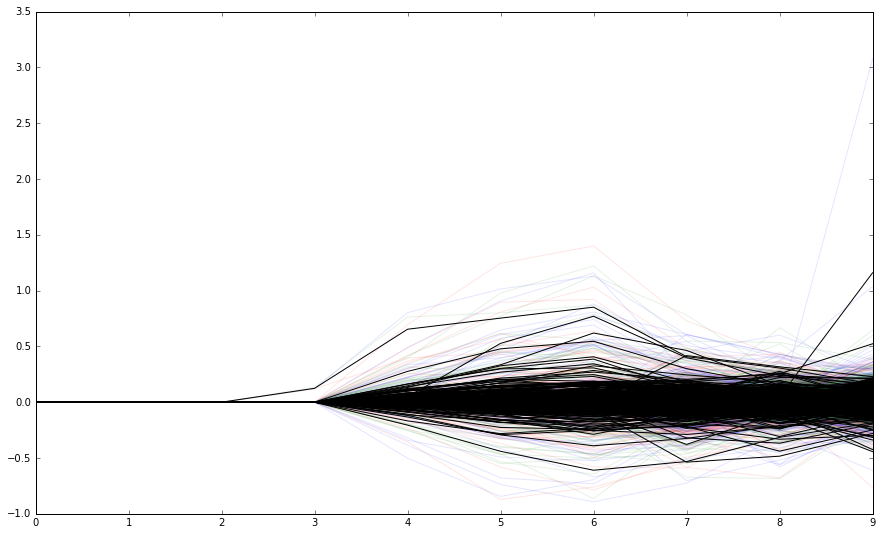

In [52]:
fig, ax = plt.subplots(figsize=(15,9))
colors = ['r', 'b', 'g']
for i in range(3):
    plt.plot(path[i,:,:], color=colors[i], alpha=.1)
plt.plot(avg, color='k')

In [78]:
b = lrs.values()[0].coef_.reshape(-1)
len(b)

6529

In [101]:
betas = np.concatenate([v.coef_ for v in lrs.values()])
betas.shape

(111, 6529)

(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 500)
(111, 29)


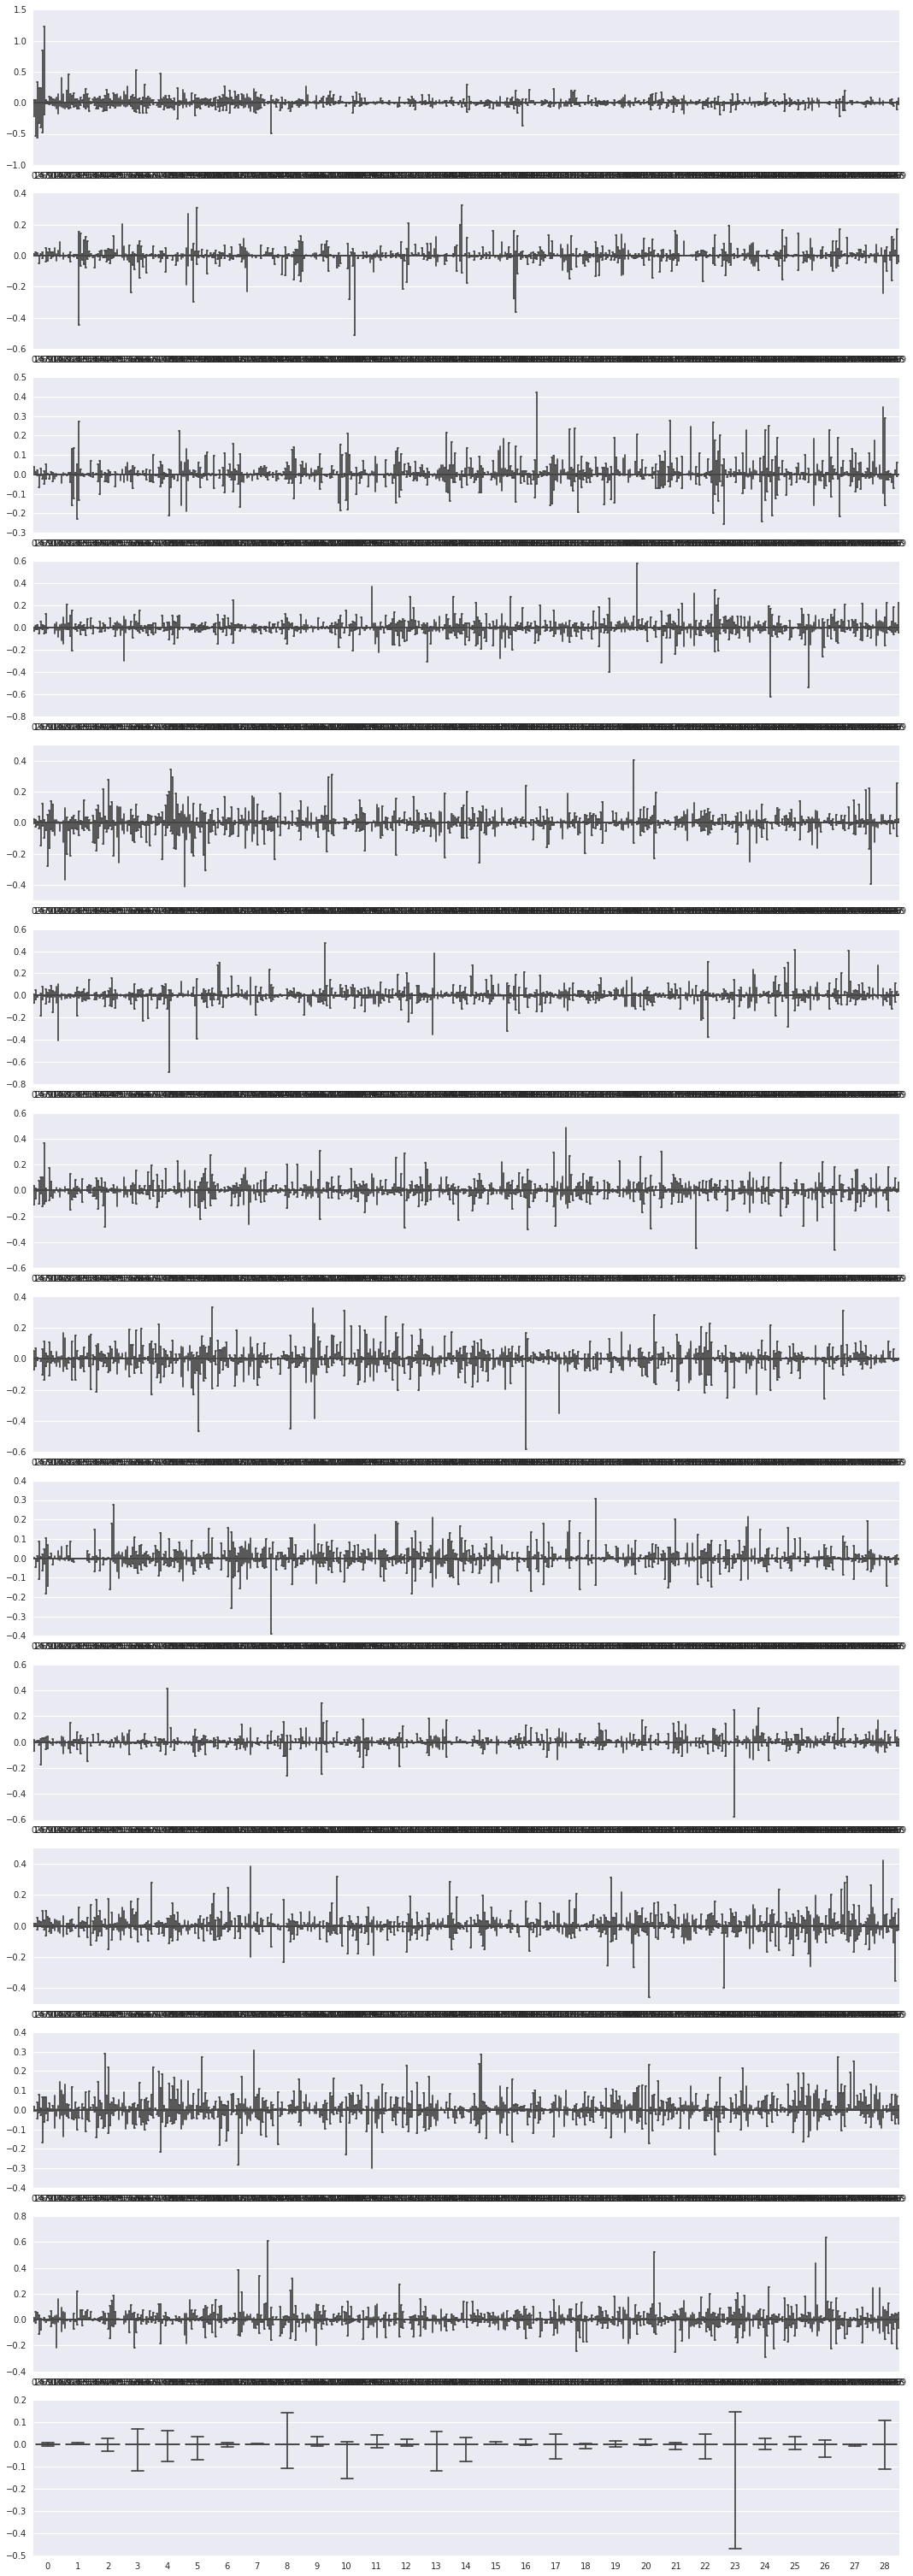

In [102]:
stride = 500
num_plots = betas.shape[1] // stride + 1
fig, ax = plt.subplots(num_plots,1, figsize=(15,3*num_plots))
for i in range(num_plots):
    minibetas = betas[:,i*stride:(i+1)*stride]
    print minibetas.shape
    sb.boxplot(data=minibetas, ax=ax[i])
plt.tight_layout()

In [103]:
# proportion that are allzeros
nonzero_betas = len([v.coef_ for v in lrs.values() if np.sum(v.coef_) > 0.0])
nonzero_betas, len(lrs.values()), nonzero_betas/float(len(lrs.values()))

(59, 111, 0.5315315315315315)

### Signal appears to be sparse, and highly variable across people

## Stability analysis across all training people

In [28]:
from sklearn.linear_model import RandomizedLogisticRegression as RLR
from sklearn.linear_model import lasso_stability_path

# supress all warnings because thise package is old and things have been deprecated
import warnings
warnings.filterwarnings('ignore')

In [241]:
Cs = np.logspace(-4,5,10)
all_rlr = RLR(C=Cs,
          scaling=.5,
          sample_fraction=.2,#.75, 
          n_resampling=100,
          selection_threshold=.5,#.75,
          normalize=False,
          random_state=random_seed,
          n_jobs=1,
          verbose=5)
%time all_rlr.fit(train_x, train_y)
print "DONE"

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done  71 tasks       | elapsed: 14.5min


CPU times: user 20min 42s, sys: 2.91 s, total: 20min 45s
Wall time: 21min 11s
DONE


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 21.2min finished


In [244]:
c_idx = list(Cs).index(1)

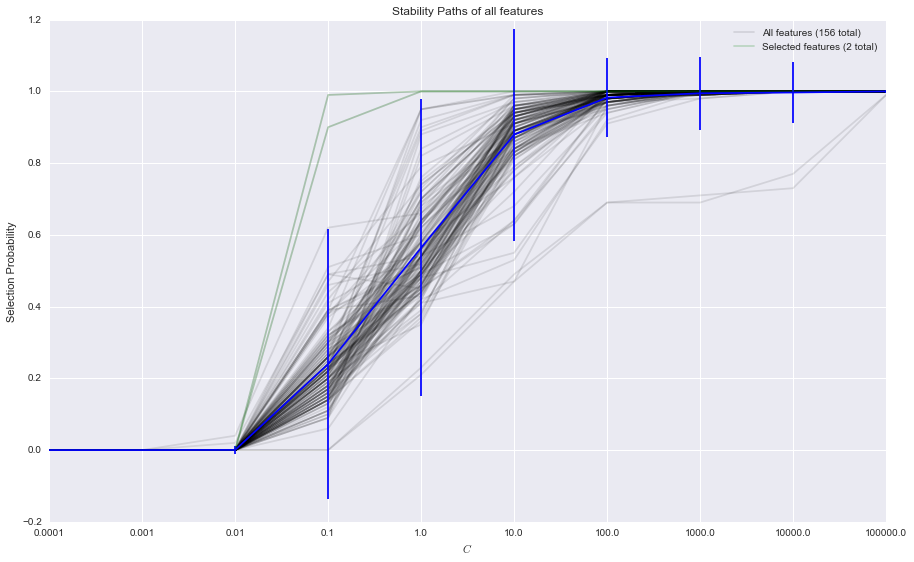

In [254]:
scores =all_rlr.all_scores_
avg = np.mean(scores.T, axis=1)
std = np.std(scores.T, axis=1)

# get the scores that are greater than 3 stddevs above average in at least one experiment
num_std = 3
thresh = avg + num_std*std
select_mask = scores[:, c_idx] > thresh[c_idx]
# print select_mask[:150]
above = scores[select_mask]
# print rlr.all_scores_.T.shape, above.shape

fig, ax = plt.subplots(1,1, figsize=(15,9))
ax.grid(zorder=0)
s = ax.plot(scores.T, 'k', alpha=.1, zorder=1, label=('All features (%i total)'%scores.shape[0]))
a = ax.plot(above.T, 'g', alpha=.2, label=('Selected features (%i total)'%above.shape[0]))
ax.set_xticks(range(len(Cs)))
ax.set_xticklabels(Cs)
e = ax.errorbar(range(len(Cs)), avg, yerr=num_std*std, color='b', ecolor='b', zorder=2, label='Mean selection w/ 3 std')
ax.set_title("Stability Paths of all features")
ax.set_xlabel('$C$')
ax.set_ylabel('Selection Probability')
ax.legend(handles=[s[0], a[0], e[0]])

In [195]:
mean_scores = np.mean(all_rlr.all_scores_, axis=1)
c_scores = all_rlr.all_scores_[:,c_idx]

In [196]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
colors = ['b', 'r', 'g', 'm']
sizes = np.cumsum([0, 
         neo['train'].shape[1]-2,
         liwc['train'].shape[1]-6,
         dal['train'].shape[1]-3,
         is13['train'].shape[1]-3])
sets = ['Neo', 'LIWC', 'DAL', 'OpenSmile']
labels = list(all_train.drop(noncovariates, axis=1).columns.values)


# print labels[:200]
for i in range(len(sizes)-1):
    left = sizes[i]
    right = sizes[i+1]
    scatter = ax.scatter(range(left, right), mean_scores[left:right], alpha=.5, color=colors[i], label=sets[i])

    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels[left:right])
    mpld3.plugins.connect(fig, tooltip)
    
l = ax.legend(fancybox=0)
ax.set_title('Mean Selection Probabilities')
for i, text in enumerate(l.get_texts()):
    text.set_color(colors[i])
mpld3.display()

0.259107060806


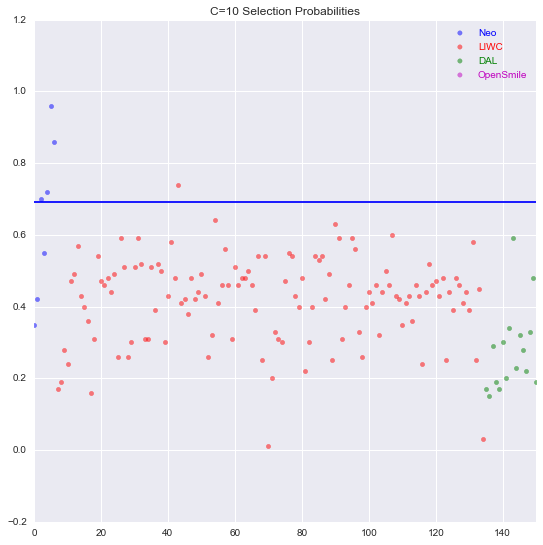

In [214]:
fig, ax = plt.subplots(1,1, figsize=(9,9))
colors = ['b', 'r', 'g', 'm']
sizes = np.cumsum([0, 
         neo['train'].shape[1]-2,
         liwc['train'].shape[1]-6,
         dal['train'].shape[1]-3,
         is13['train'].shape[1]-3])
sets = ['Neo', 'LIWC', 'DAL', 'OpenSmile']
labels = list(all_train.drop(noncovariates, axis=1).columns.values)
# print labels[:200]
for i in range(len(sizes)-1):
    left = sizes[i]
    right = sizes[i+1]
    scatter = ax.scatter(range(left, right), c_scores[left:right], alpha=.5, color=colors[i], label=sets[i])

#     tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels[left:right])
#     mpld3.plugins.connect(fig, tooltip)
    
a = avg[c_idx]
print a
s = std[c_idx]
ax.axhline(y=a+3*s, xmin=0, xmax=7000)    
ax.set_xlim(0,150)
l = ax.legend(fancybox=0)
ax.set_title('C=10 Selection Probabilities')
for i, text in enumerate(l.get_texts()):
    text.set_color(colors[i])
# mpld3.display()

### Now fit Ridge Regression w/  and w/o stability selected features

In [255]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid = dict(
                  penalty=['l2'], 
#                   dual=False, 
#                   tol=0.0001, 
                  C=[1],#Cs, 
#                   fit_intercept=True, 
#                   intercept_scaling=1, 
#                   class_weight=None, 
#                   random_state=random_seed, 
#                   solver='liblinear', 
#                   max_iter=100, 
#                   multi_class='ovr', 
#                   verbose=0, 
#                   warm_start=False, 
#                   n_jobs=1
                 )

print select_mask
sm_train_x = train_x[:,select_mask]
sm_test_x = test_x[:, select_mask]
print sm_train_x.shape
lr2_results = experiment(lr, param_grid,
                         train_x=sm_train_x, 
                         test_x=sm_test_x, cv=5)

[False False False False False  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
(7246, 2)
Searching Grid...
Fitting 5 folds for ea

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


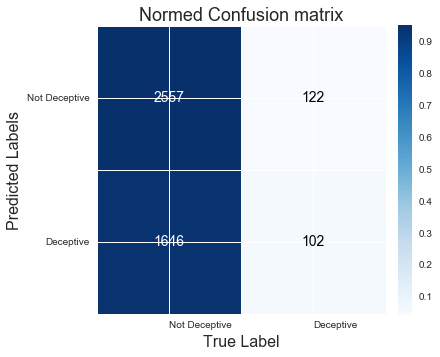

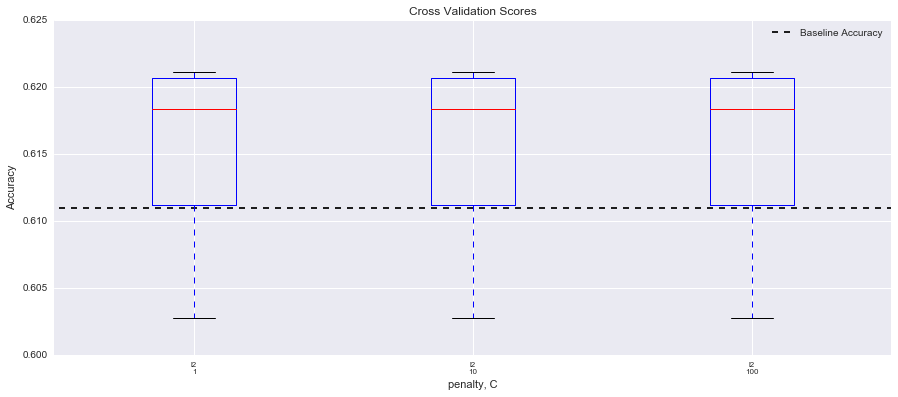

In [202]:
plot_confusion_matrix(lr2_results['cm'])
plot_grid_scores(lr2_results['grid_scores'])

In [249]:
lr = LR(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid = dict(
                  penalty=['l2'], 
#                   dual=False, 
#                   tol=0.0001, 
                  C=Cs, 
#                   fit_intercept=True, 
#                   intercept_scaling=1, 
#                   class_weight=None, 
#                   random_state=random_seed, 
#                   solver='liblinear', 
#                   max_iter=100, 
#                   multi_class='ovr', 
#                   verbose=0, 
#                   warm_start=False, 
#                   n_jobs=1
                 )
lr_all_results = experiment(lr, param_grid, cv=5)

Searching Grid...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   56.6s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   58.8s finished


Fitting best estimator...
Chosen parameters: 
{'penalty': 'l2', 'C': 1.0}
Best Estimator: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Evaluating on Test...
Test Accuracy: 0.5939, Test F1: 0.2100 (P:0.45 R:0.14)


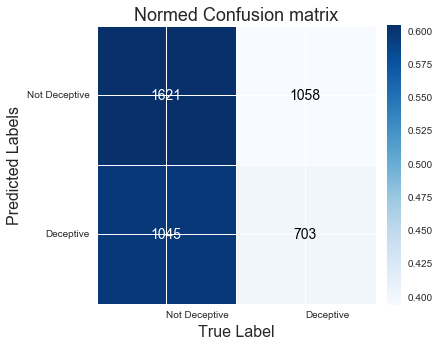

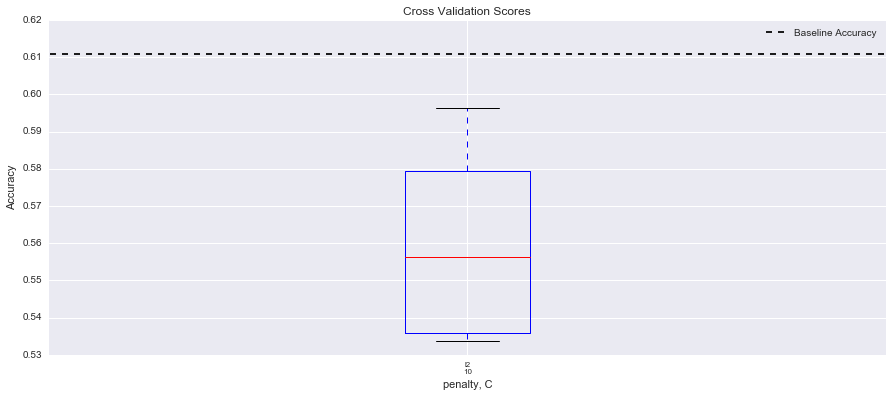

In [67]:
plot_confusion_matrix(lr_all_results['cm'])
plot_grid_scores(lr_all_results['grid_scores'])

In [256]:
imports = sorted(zip(list(np.array(feature_labels)[select_mask]), 
                     list(lr2_results['clf'].coef_.reshape(-1))), 
                 key=lambda x:x[1], reverse=True)
for i, (l, f) in enumerate(imports[:30]):
    print "%i :: %2.4f : %s" % (i, f,l)

0 :: 0.0982 : Cscore_raw
1 :: -0.1271 : Ascore_raw


In [66]:
all_imports = sorted(zip(feature_labels, list(lr_all_results['clf'].coef_.reshape(-1))), key=lambda x:x[1], reverse=True)
for l, f in all_imports[:20]:
    print "%2.4f : %s" % (f,l)

2.3726 : pcm_zcr_sma_linregc1
2.3515 : pcm_Mag_harmonicity_sma_de_meanSegLen
2.2154 : pcm_Mag_fband250-650_sma_de_peakRangeAbs
2.1410 : audspec_lengthL1norm_sma_minSegLen
2.1079 : pcm_Mag_harmonicity_sma_qregc1
2.0465 : jitterLocal_sma_de_quartile1
2.0438 : pcm_Mag_spectralEntropy_sma_de_peakRangeAbs
2.0274 : mfcc_sma_de[9]_upleveltime25
2.0157 : jitterDDP_sma_upleveltime50
2.0018 : audSpec_Rfilt_sma_de[16]_lpgain
1.9997 : pcm_Mag_spectralKurtosis_sma_de_upleveltime25
1.9888 : audSpec_Rfilt_sma[10]_quartile1
1.9812 : audSpec_Rfilt_sma_de[0]_percentile1.0
1.9732 : pcm_Mag_spectralFlux_sma_percentile1.0
1.9641 : audspec_lengthL1norm_sma_de_posamean
1.9172 : pcm_Mag_spectralEntropy_sma_de_lpgain
1.9072 : pcm_Mag_spectralSlope_sma_de_iqr1-2
1.8924 : pcm_Mag_harmonicity_sma_range
1.8719 : audSpec_Rfilt_sma_de[21]_posamean
1.8173 : LIWC_assent


## Random Forest with stability selectiom

In [208]:
# RF with preselcted by sta
rf = RF(verbose=0, n_jobs=-1, random_state=random_seed)
param_grid =dict(n_estimators=[200],#[5, 10, 50, 100, 200, 300], 
                 criterion=['entropy'],
                 max_features=[None],#['log2', 'sqrt']
#                  max_depth=None, 
#                  min_samples_split=2, 
#                  min_samples_leaf=1, 
#                  min_weight_fraction_leaf=0.0, 
#                  max_features=['auto', 10], 
#                  max_leaf_nodes=None, 
#                  bootstrap=True, 
#                  oob_score=False, 
#                  n_jobs=1, 
#                  random_state=None, 
#                  verbose=0, 
#                  warm_start=False, 
#                  class_weight=None
                )
rf_results = experiment(rf, param_grid, 
                        train_x=sm_train_x, test_x=sm_test_x,
                        cv=10)

Searching Grid...
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished


Fitting best estimator...
Chosen parameters: 
{'max_features': None, 'n_estimators': 200, 'criterion': 'entropy'}
Best Estimator: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Evaluating on Test...
Test Accuracy: 0.5909, Test F1: 0.1787 (P:0.43 R:0.11)


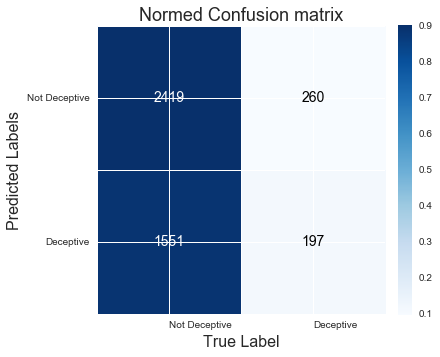

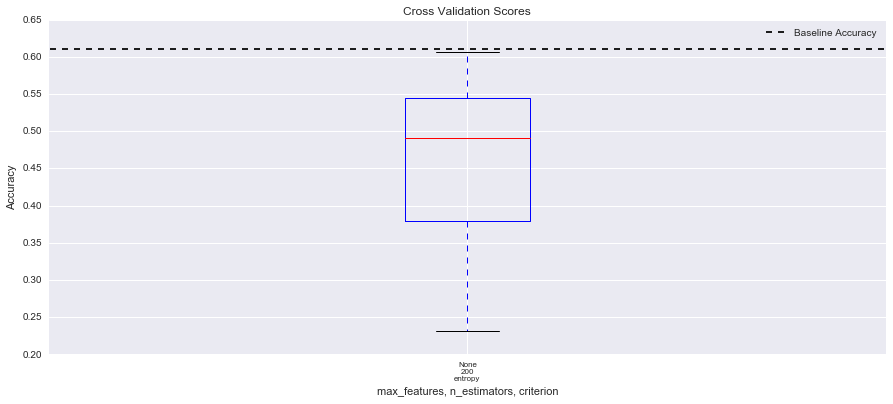

In [209]:
plot_confusion_matrix(rf_results['cm'])
plot_grid_scores(rf_results['grid_scores'])

In [218]:
imports = sorted(zip(list(np.array(feature_labels)[select_mask]), 
                     list(rf_results['clf'].feature_importances_.reshape(-1))), 
                 key=lambda x:x[1], reverse=True)
for i, (l, f) in enumerate(imports[:30]):
    print "%i :: %2.4f : %s" % (i, f,l)

0 :: 0.0470 : mfcc_sma[8]_maxPos
1 :: 0.0468 : mfcc_sma[12]_maxPos
2 :: 0.0459 : mfcc_sma_de[4]_maxPos
3 :: 0.0459 : mfcc_sma_de[9]_maxPos
4 :: 0.0443 : mfcc_sma[7]_minPos
5 :: 0.0439 : mfcc_sma[6]_minPos
6 :: 0.0439 : mfcc_sma_de[14]_maxPos
7 :: 0.0436 : pcm_Mag_harmonicity_sma_de_minPos
8 :: 0.0435 : audSpec_Rfilt_sma_de[22]_peakMeanRel
9 :: 0.0418 : pcm_Mag_spectralVariance_sma_de_peakMeanRel
10 :: 0.0414 : mfcc_sma_de[5]_peakMeanRel
11 :: 0.0412 : mfcc_sma_de[7]_peakMeanRel
12 :: 0.0412 : mfcc_sma_de[12]_peakMeanRel
13 :: 0.0410 : mfcc_sma_de[2]_peakMeanRel
14 :: 0.0409 : pcm_Mag_spectralSlope_sma_de_peakMeanRel
15 :: 0.0395 : pcm_Mag_spectralKurtosis_sma_de_peakMeanRel
16 :: 0.0392 : mfcc_sma_de[8]_peakMeanRel
17 :: 0.0383 : audSpec_Rfilt_sma_de[8]_peakMeanRel
18 :: 0.0381 : audSpec_Rfilt_sma_de[23]_peakMeanRel
19 :: 0.0374 : audSpec_Rfilt_sma_de[18]_peakMeanRel
20 :: 0.0292 : audSpec_Rfilt_sma_de[19]_minSegLen
21 :: 0.0281 : jitterLocal_sma_de_lpc4
22 :: 0.0276 : LIWC_tentat_func

## Clustering of per person covariates using stability selection analysis

In [85]:
train_pids = all_train.index.get_level_values(level=0).unique()

In [86]:
all_train[all_train.index.get_level_values('pid') == 268]['label'].as_matrix()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [87]:
rlrs = {}
for i, pid in enumerate(train_pids[:]):
    X = all_train[all_train.index.get_level_values('pid') == pid].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('pid') == pid]['label'].as_matrix()
    if len(np.unique(y)) < 2: 
        print "Bad PID: %i" % pid
        continue
    Cs = np.logspace(-4,5,10)
    rlr = RLR(C=Cs,
          scaling=.5,
          sample_fraction=.5,#.75, 
          n_resampling=200,
          selection_threshold=.5,#.75,
          normalize=False,
          random_state=random_seed,
          n_jobs=1)    
    print "%i :: PID: %i, n: %r" % (i, pid, X.shape[0])
#     lsp = lasso_stability_path(X, y,
#                                scaling=.5,
#                                random_state=random_seed,
#                                n_resampling=5,#200,
#                                n_grid=5,#100,
#                                sample_fraction=0.5,#0.75,
#                                eps =.1,
#                                n_jobs=-1,
#                                verbose=True)
    try:
        rlr.fit(X, y)
    except ValueError:
        print "Subsampling Value Error for Bad PID: %i" % pid
        continue
    rlrs[pid] = rlr
print "DONE"

0 :: PID: 205, n: 134
1 :: PID: 210, n: 86
2 :: PID: 213, n: 39
3 :: PID: 212, n: 31
4 :: PID: 225, n: 70
5 :: PID: 216, n: 34
6 :: PID: 221, n: 79
7 :: PID: 220, n: 117
8 :: PID: 236, n: 122
9 :: PID: 224, n: 42
10 :: PID: 229, n: 41
11 :: PID: 226, n: 113
12 :: PID: 228, n: 51
13 :: PID: 231, n: 59
14 :: PID: 230, n: 61
15 :: PID: 237, n: 101
16 :: PID: 243, n: 87
17 :: PID: 242, n: 39
18 :: PID: 245, n: 36
19 :: PID: 244, n: 40
20 :: PID: 248, n: 91
21 :: PID: 246, n: 80
22 :: PID: 249, n: 60
23 :: PID: 257, n: 113
24 :: PID: 253, n: 62
25 :: PID: 252, n: 107
26 :: PID: 255, n: 158
27 :: PID: 254, n: 84
28 :: PID: 279, n: 49
29 :: PID: 256, n: 114
30 :: PID: 261, n: 79
31 :: PID: 260, n: 93
32 :: PID: 263, n: 51
33 :: PID: 262, n: 45
34 :: PID: 264, n: 54
35 :: PID: 265, n: 96
36 :: PID: 269, n: 55
37 :: PID: 268, n: 47
Subsampling Value Error for Bad PID: 268
38 :: PID: 271, n: 39
39 :: PID: 270, n: 39
40 :: PID: 273, n: 66
41 :: PID: 272, n: 36
42 :: PID: 274, n: 146
43 :: PID: 27

## Do a per person cross validated lasso to get the best C for performance

In [88]:
from sklearn.linear_model import LogisticRegressionCV as LRCV
train_pids = all_train.index.get_level_values(level=0).unique()
print Cs

[  1.00000000e-04   1.00000000e-03   1.00000000e-02   1.00000000e-01
   1.00000000e+00   1.00000000e+01   1.00000000e+02   1.00000000e+03
   1.00000000e+04   1.00000000e+05]


In [89]:
lrs = {}
for i, pid in enumerate(train_pids):
    lrcv = LRCV(Cs=Cs,
                cv=5,
                penalty='l1', 
                n_jobs=-1, 
                refit=False, 
                random_state=random_seed, 
                solver='liblinear')
    X = all_train[all_train.index.get_level_values('pid') == pid].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('pid') == pid]['label'].as_matrix()
    print "%i :: PID: %i, n: %r" % (i, pid, X.shape[0])
    lrcv.fit(X, y)
    lrs[pid] = lrcv

0 :: PID: 205, n: 134
1 :: PID: 210, n: 86
2 :: PID: 213, n: 39
3 :: PID: 212, n: 31
4 :: PID: 225, n: 70
5 :: PID: 216, n: 34
6 :: PID: 221, n: 79
7 :: PID: 220, n: 117
8 :: PID: 236, n: 122
9 :: PID: 224, n: 42
10 :: PID: 229, n: 41
11 :: PID: 226, n: 113
12 :: PID: 228, n: 51
13 :: PID: 231, n: 59
14 :: PID: 230, n: 61
15 :: PID: 237, n: 101
16 :: PID: 243, n: 87
17 :: PID: 242, n: 39
18 :: PID: 245, n: 36
19 :: PID: 244, n: 40
20 :: PID: 248, n: 91
21 :: PID: 246, n: 80
22 :: PID: 249, n: 60
23 :: PID: 257, n: 113
24 :: PID: 253, n: 62
25 :: PID: 252, n: 107
26 :: PID: 255, n: 158
27 :: PID: 254, n: 84
28 :: PID: 279, n: 49
29 :: PID: 256, n: 114
30 :: PID: 261, n: 79
31 :: PID: 260, n: 93
32 :: PID: 263, n: 51
33 :: PID: 262, n: 45
34 :: PID: 264, n: 54
35 :: PID: 265, n: 96
36 :: PID: 269, n: 55
37 :: PID: 268, n: 47
38 :: PID: 271, n: 39
39 :: PID: 270, n: 39
40 :: PID: 273, n: 66
41 :: PID: 272, n: 36
42 :: PID: 274, n: 146
43 :: PID: 277, n: 144
44 :: PID: 278, n: 58
45 :: PID

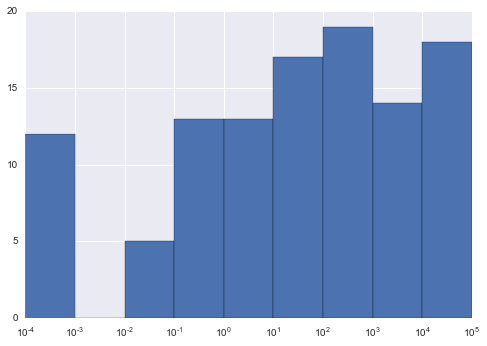

In [90]:
selected_cs = pd.Series([v.C_ for v in lrs.values() ])
fig, ax = plt.subplots()
selected_cs.hist(ax=ax, bins=Cs)
ax.set_xscale('log')
print

Looks like theyre quite variable, but centered around $C=100$, so we'll look at variable selection using the threshold at $C=100$

In [91]:
c_idx =list(Cs).index(100)
print c_idx

6


## Visualize the stability selections at $C=100$

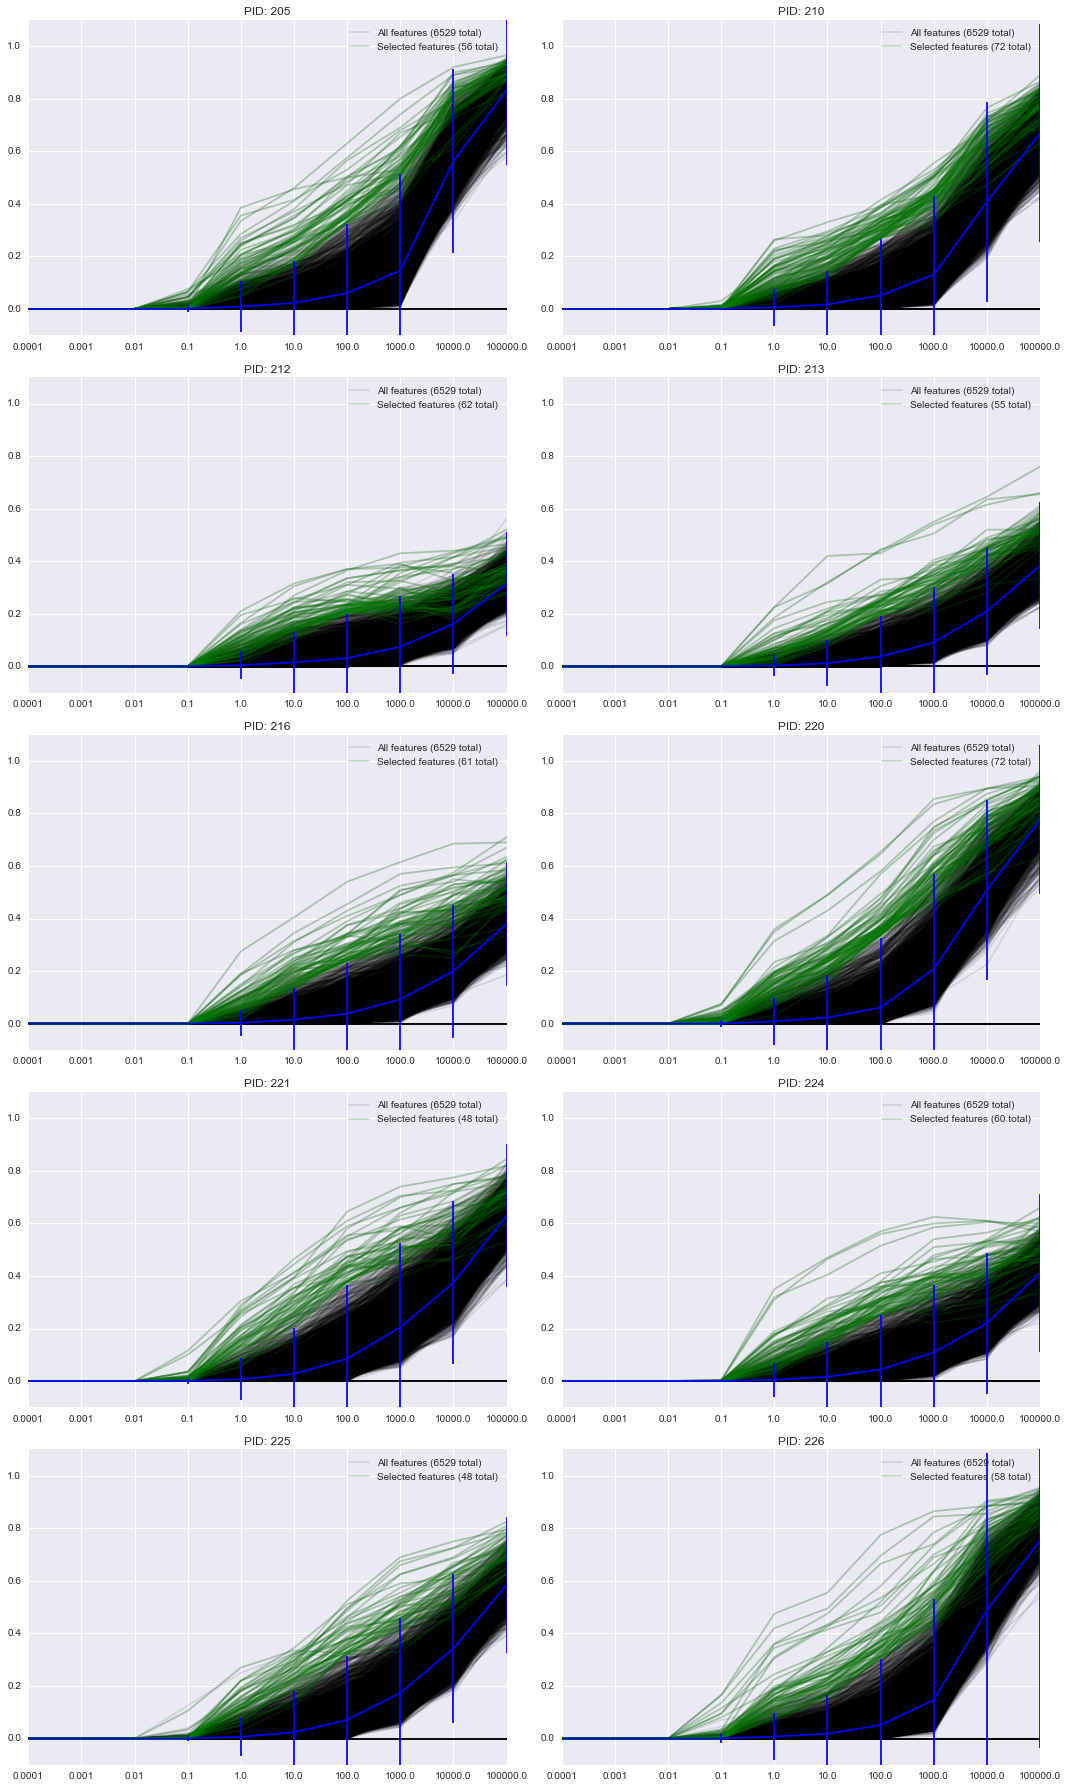

In [92]:
num = 10#len(rlrs)
nrows = num//2 if num % 2 == 0 else num//2+1
fig, axes = plt.subplots(nrows, 2, sharey=False, sharex=False, figsize=(15, nrows*5))
feature_indicators = {}
for i, (pid, rlr) in enumerate(rlrs.items()[:num]):
    ax = axes[i//2, i%2]
    scores = rlr.all_scores_
    avg = np.mean(scores.T, axis=1)
    std = np.std(scores.T, axis=1)

    # get the scores that are greater than 3 stddevs above average in at least one experiment
    num_std = 4
    thresh = avg + num_std*std
#     select_mask = np.any(scores[:, c_dx] > thresh[:,c_idx], axis=1) # all
    select_mask = scores[:, c_idx] > thresh[c_idx] # only at one c
    above = scores[select_mask]
    # print rlr.all_scores_.T.shape, above.shape

    ax.grid(zorder=0)
    s = ax.plot(scores.T, 'k', alpha=.1, zorder=1, label=('All features (%i total)'%scores.shape[0]))
    a = ax.plot(above.T, 'g', alpha=.2, zorder=2, label=('Selected features (%i total)'%above.shape[0]))
    ax.set_xticks(range(len(Cs)))
    ax.set_xticklabels(Cs)
    e = ax.errorbar(range(len(Cs)), avg, yerr=num_std*std, color='b', ecolor='b', zorder=3, label='Mean selection w/ 3 std')
#     ax.set_title("Stability Paths of all features")
#     ax.set_xlabel('$C$')
#     ax.set_ylabel('Selection Probability')
    ax.legend(handles=[s[0], a[0], e[0]])
    ax.set_title('PID: %i' % pid)
    ax.set_ylim(0.-.1,1.1)
#     ax.axvline(c_idx, ymin=-.1, ymax=1.1)
    
    # keep the selection vector
#     feature_indicators[pid] = select_mask.astype(np.int).reshape(-1,1)
fig.tight_layout()

In [57]:
scores =rlrs.values()[0].all_scores_
scores.shape, c_idx

((6529, 10), 6)

(6529,)


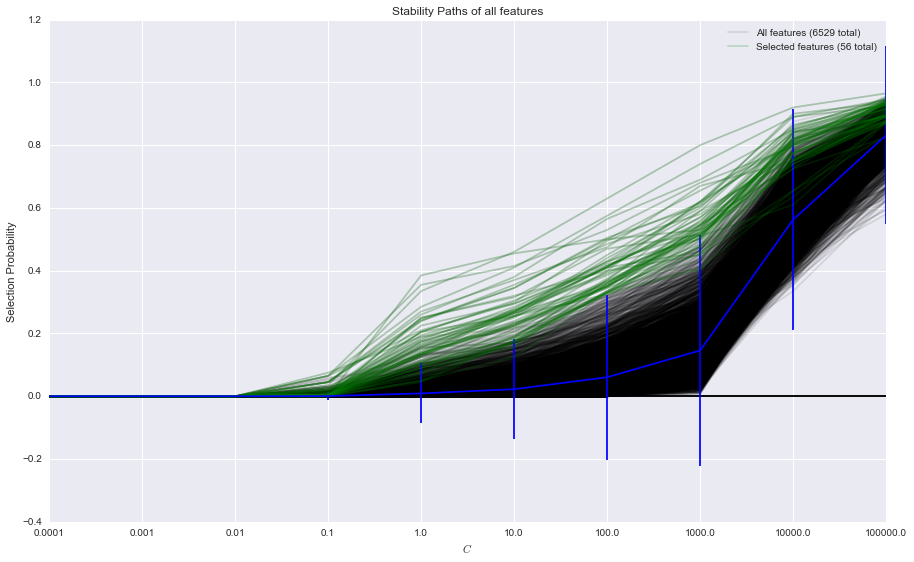

In [142]:
scores =rlrs.values()[0].all_scores_
avg = np.mean(scores.T, axis=1)
std = np.std(scores.T, axis=1)

# get the scores that are greater than 3 stddevs above average in at least one experiment
num_std = 4
thresh = avg + num_std*std
select_mask = scores[:, c_idx] > thresh[c_idx]
print select_mask.shape
above = scores[select_mask]
# print rlr.all_scores_.T.shape, above.shape

fig, ax = plt.subplots(1,1, figsize=(15,9))
ax.grid(zorder=0)
s = ax.plot(scores.T, 'k', alpha=.1, zorder=1, label=('All features (%i total)'%scores.shape[0]))
a = ax.plot(above.T, 'g', alpha=.2, label=('Selected features (%i total)'%above.shape[0]))
ax.set_xticks(range(len(Cs)))
ax.set_xticklabels(Cs)
e = ax.errorbar(range(len(Cs)), avg, yerr=num_std*std, color='b', ecolor='b', zorder=2, label='Mean selection w/ 3 std')
ax.set_title("Stability Paths of all features")
ax.set_xlabel('$C$')
ax.set_ylabel('Selection Probability')
ax.legend(handles=[s[0], a[0], e[0]])

In [233]:
thresh = avg + 3*std
s = rlr.all_scores_
s[np.any(s > thresh, axis=1)].shape

(196, 10)

In [243]:
vec = np.any(scores > thresh, axis=1).astype(np.int)

True


In [93]:
# from copy import deepcopy
# rlrs_copy = deepcopy(rlrs)

In [139]:
from copy import copy
rlrs = deepcopy(rlrs_copy)

In [140]:
def select_stable(num_std=3):
    feature_indicators = {}
    rlrs = deepcopy(rlrs_copy)
    num = len(rlrs)
    for i, (pid, rlr) in enumerate(rlrs.items()[:num]):
        scores = copy(rlr.all_scores_)
        avg = np.mean(scores.T, axis=1)
        std = np.std(scores.T, axis=1)

        # get the scores that are greater than 3 stddevs above average in at least one experiment
#         num_std = 
        thresh = avg + num_std*std
    #     select_mask = np.any(scores > thresh, axis=1) #all
        select_mask = scores[:, c_idx] > thresh[c_idx] # best C
        above = scores[select_mask]
        scores[~select_mask] = 0
        scores[select_mask] = 1 #above[c_idx] # 1
        feature_indicators[pid] = scores.reshape(-1,1)
    pids = feature_indicators.keys()
    var_ind = np.concatenate(feature_indicators.values(), axis=1).T
    return var_ind, pids

## Any variable selection clusterings?

In [97]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
# var_ind = select_stable(2)[:,:]
# U, D, V = np.linalg.svd(var_ind)

In [102]:
pids = feature_indicators.keys()

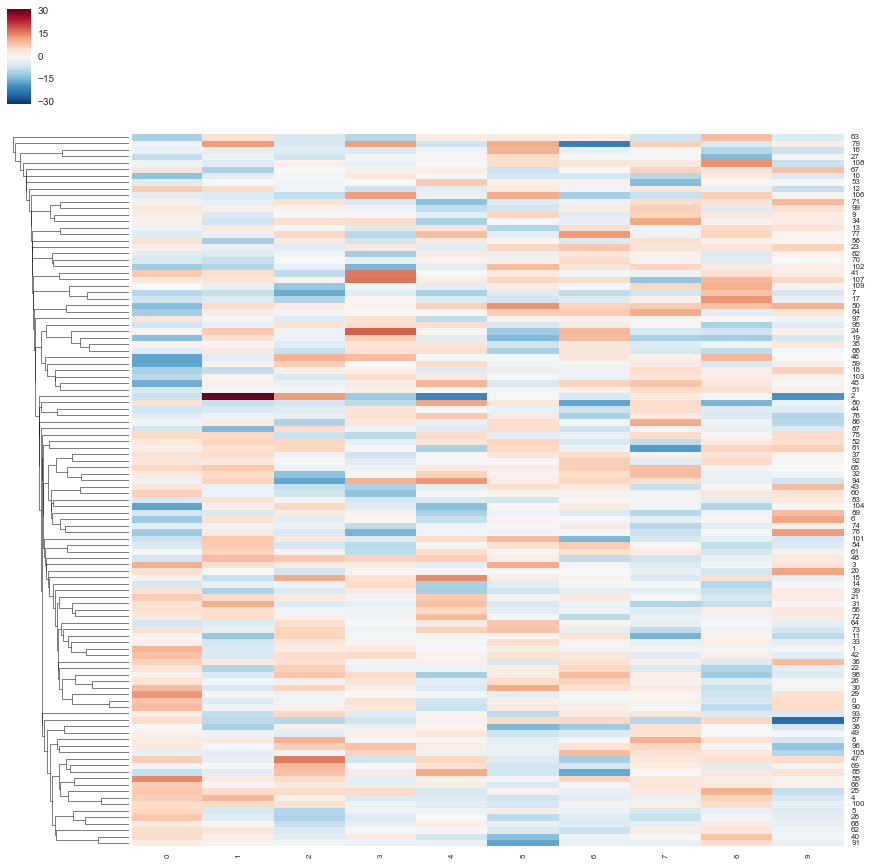

In [106]:
var_ind, pids = select_stable(2)

# fig, ax = plt.subplots(1,1, figsize=(15,12))
# ax.imshow(var_ind, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
# ax.set_yticks(range(len(pids)))
# ax.set_yticklabels(pids)
# plt.title("Selected Variables $> 2\sigma$ at $C=100$")
# avg_row_count = np.mean((var_ind != 0).sum(1))
# ax.set_xlabel('Average nonzero count per row %2.4f' % avg_row_count)
# print ''

pca = PCA(n_components=10)
medd = pca.fit_transform(var_ind)

# fig, ax = plt.subplots(1,1, figsize=(15,18))
# ax.set_title('1000 D PCA embeddings')
# im = ax.imshow(medd, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
# ax.set_yticks(range(len(pids)))
# ax.set_yticklabels(pids)
# plt.colorbar(im, fraction=0.046, pad=0.04)
# print ''

g = sb.clustermap(medd, method='single', metric='cosine', 
                  figsize=(15,15), row_cluster=True, col_cluster=False)
heatmap = g.ax_heatmap
labels = heatmap.get_yticklabels()
heatmap.set_yticklabels(labels, rotation=0, fontsize=8)
labels = heatmap.get_xticklabels()
heatmap.set_xticklabels(labels, rotation=90, fontsize=8)
print

pca = PCA(n_components=2)
lowd = pca.fit_transform(var_ind)

fig, ax = plt.subplots(figsize=(9,9))
ax.set_title('2D PCA embeddings')
scatter = ax.scatter(lowd[:,0], lowd[:,1])
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# lowd = tsne.fit_transform(var_ind)

# fig, ax = plt.subplots(figsize=(9,9))
# ax.set_title('2D TSNE embeddings')

# scatter = ax.scatter(lowd[:,0], lowd[:,1])
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.display()



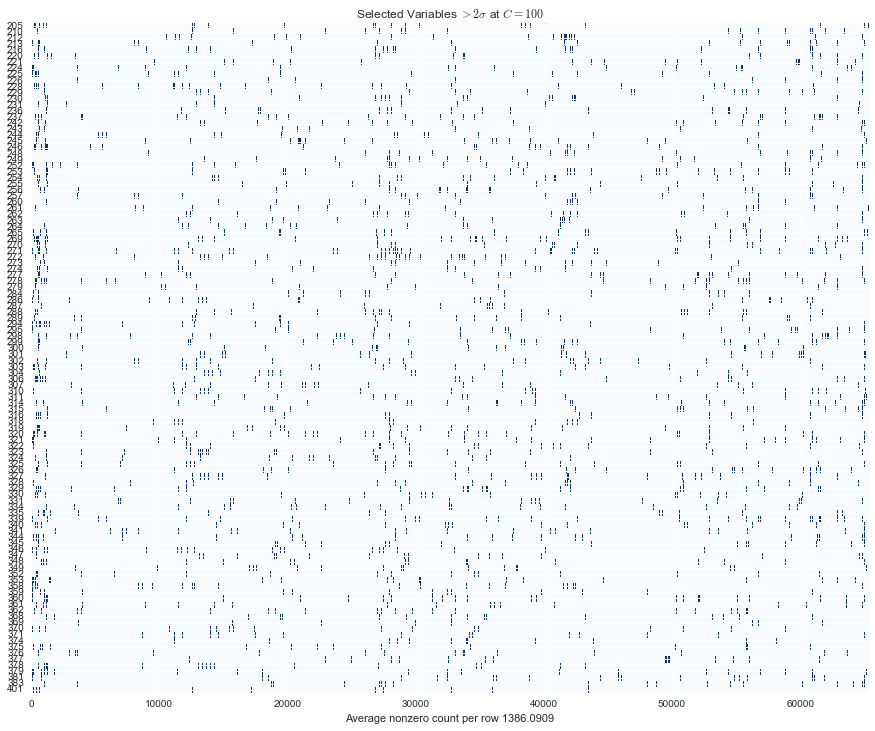

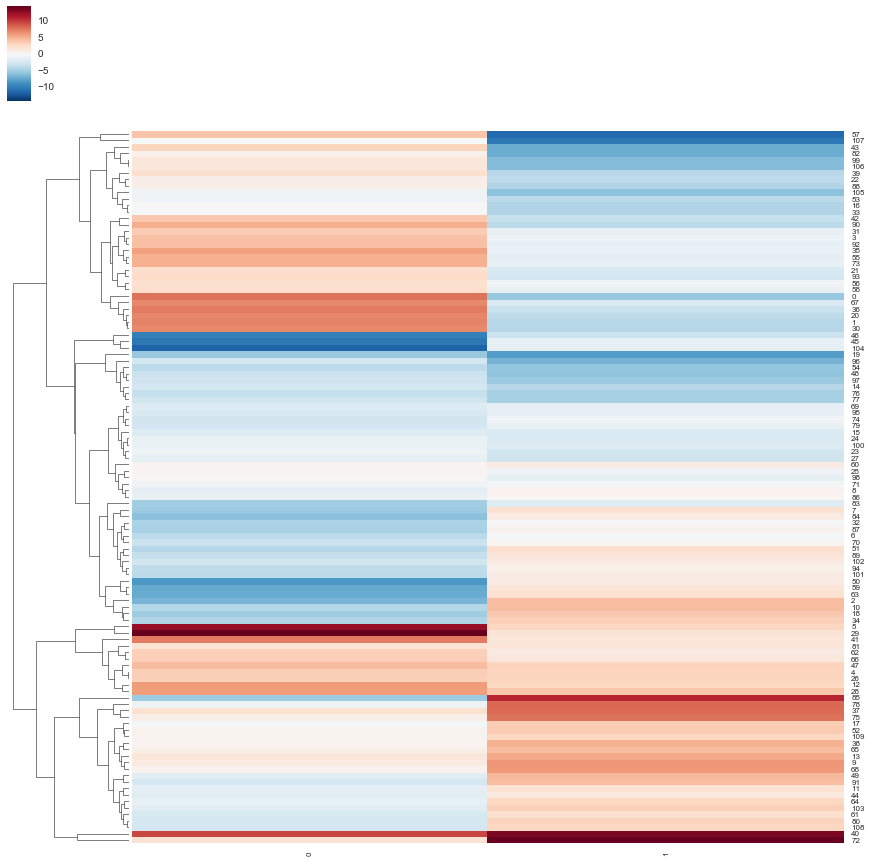

In [143]:
var_ind, pids = select_stable(3)

fig, ax = plt.subplots(1,1, figsize=(15,12))
ax.imshow(var_ind, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
ax.set_yticks(range(len(pids)))
ax.set_yticklabels(pids)
plt.title("Selected Variables $> 2\sigma$ at $C=100$")
avg_row_count = np.mean((var_ind != 0).sum(1))
ax.set_xlabel('Average nonzero count per row %2.4f' % avg_row_count)
print ''

pca = PCA(n_components=2)
medd = pca.fit_transform(var_ind)

# fig, ax = plt.subplots(1,1, figsize=(15,18))
# ax.set_title('1000 D PCA embeddings')
# im = ax.imshow(medd, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
# ax.set_yticks(range(len(pids)))
# ax.set_yticklabels(pids)
# plt.colorbar(im, fraction=0.046, pad=0.04)
# print ''

g = sb.clustermap(medd, method='weighted', metric='euclidean', 
                  figsize=(15,15), row_cluster=True, col_cluster=False)
heatmap = g.ax_heatmap
labels = heatmap.get_yticklabels()
heatmap.set_yticklabels(labels, rotation=0, fontsize=8)
labels = heatmap.get_xticklabels()
heatmap.set_xticklabels(labels, rotation=90, fontsize=8)
print

pca = PCA(n_components=2)
lowd = pca.fit_transform(var_ind)

fig, ax = plt.subplots(figsize=(9,9))
ax.set_title('2D PCA embeddings')
scatter = ax.scatter(lowd[:,0], lowd[:,1])
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# lowd = tsne.fit_transform(var_ind)

# fig, ax = plt.subplots(figsize=(9,9))
# ax.set_title('2D TSNE embeddings')

# scatter = ax.scatter(lowd[:,0], lowd[:,1])
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.display()



In [117]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

ERROR! Session/line number was not unique in database. History logging moved to new session 332


In [ ]:
def sparse_to_prox(sparse, metric='cosine'):
    n = sparse.shape[0]
    prox = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            dist  = pdist(sparse[i])

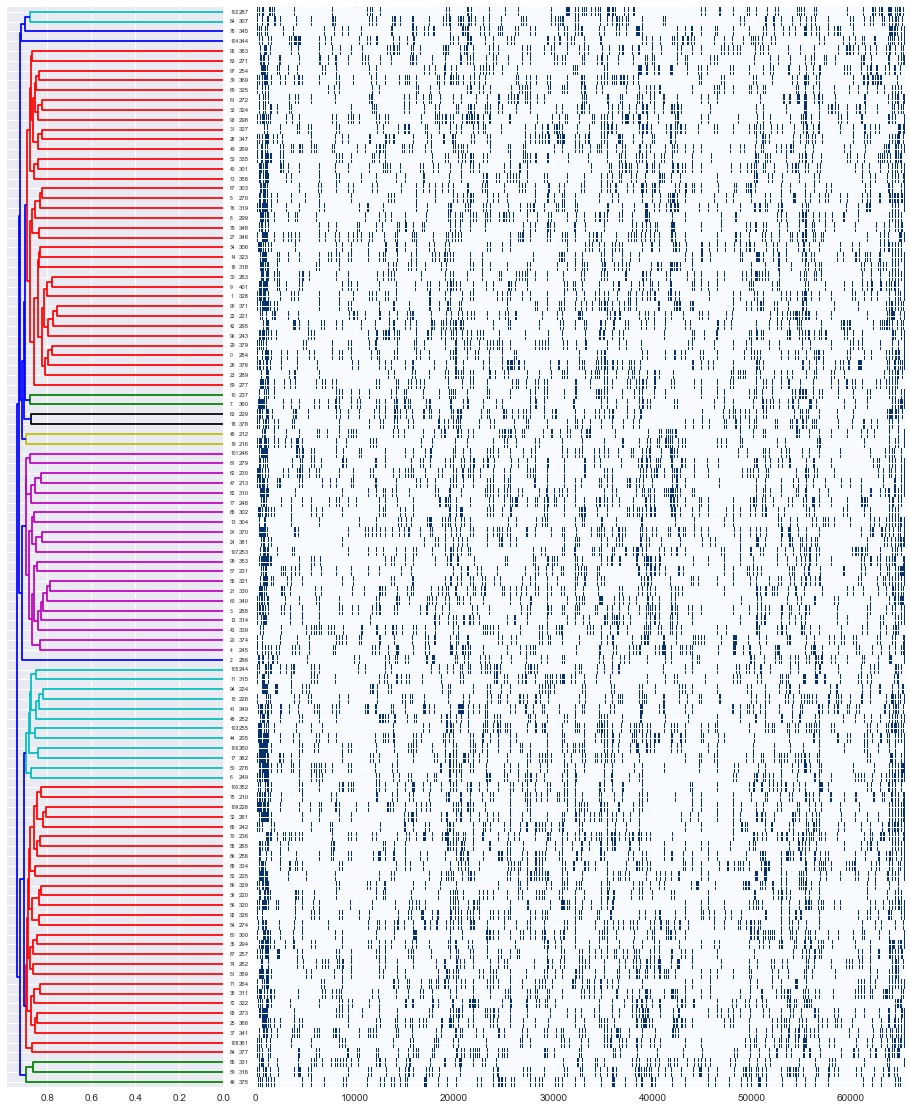

In [167]:
var_ind, pids = select_stable(a)
# dendrogram ax
fig = plt.figure(figsize=(15,15))
axd = fig.add_axes([0.09,0.1,0.2,1])
# var_ind, pids = select_stable(4)
links = linkage(var_ind, method='complete', metric='jaccard')
dend = dendrogram(links, color_threshold=.9, orientation='left')
# axd.set_xticks([])
# axd.set_yticks([])

# matrix ax
axm = fig.add_axes([0.32,0.1,0.6,1])
var_ind = var_ind[dend['leaves'],:]
axm.imshow(var_ind, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
axm.set_yticks(range(len(pids)))
pids = np.array(pids)[dend['leaves']]
axm.set_yticklabels(pids, fontsize=6)
# axm.set_yticks(pids)
print

In [ ]:
var_ind, pids = select_stable(3)

# do pca first

# dendrogram ax
fig = plt.figure(figsize=(15,15))
axd = fig.add_axes([0.09,0.1,0.2,1])
# var_ind, pids = select_stable(4)
links = linkage(var_ind, method='complete', metric='jaccard')
dend = dendrogram(links, color_threshold=.9, orientation='left')
# axd.set_xticks([])
# axd.set_yticks([])

# matrix ax
axm = fig.add_axes([0.32,0.1,0.6,1])
var_ind = var_ind[dend['leaves'],:]
axm.imshow(var_ind, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
axm.set_yticks(range(len(pids)))
pids = np.array(pids)[dend['leaves']]
axm.set_yticklabels(pids, fontsize=6)
# axm.set_yticks(pids)
print

IndexError: positional indexers are out-of-bounds

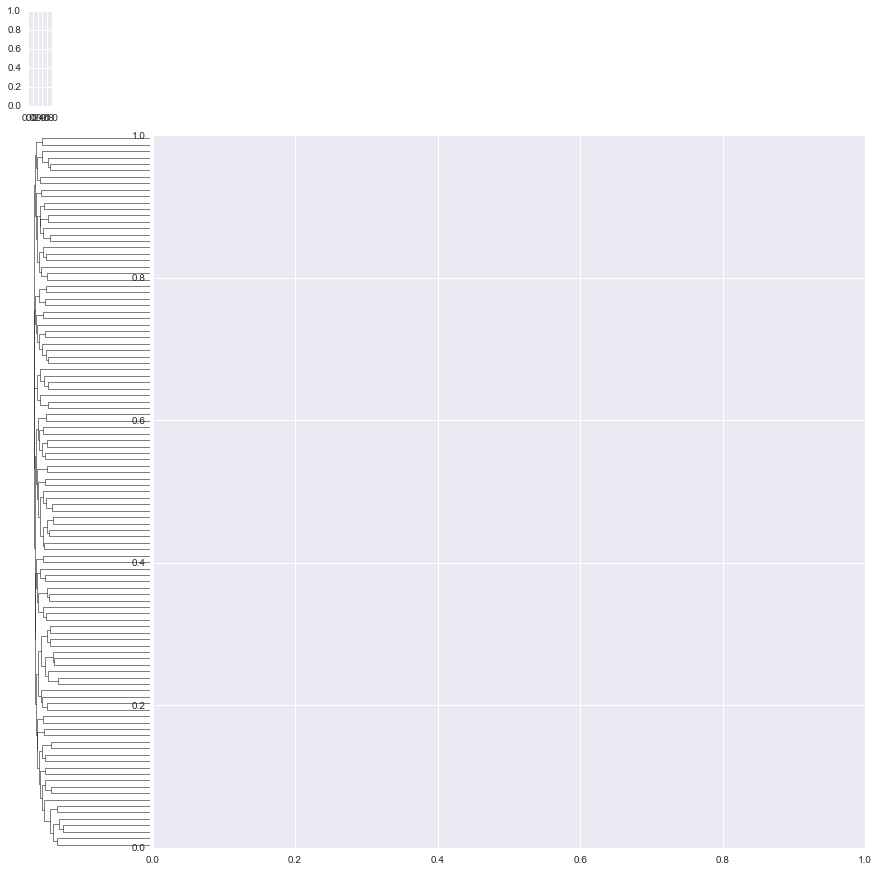

In [191]:
var_ind, pids = select_stable(3)

# fig, ax = plt.subplots(1,1, figsize=(15,12))
# ax.imshow(var_ind, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
# ax.set_yticks(range(len(pids)))
# ax.set_yticklabels(pids)
# plt.title("Selected Variables $> 2\sigma$ at $C=100$")
# avg_row_count = np.mean((var_ind != 0).sum(1))
# ax.set_xlabel('Average nonzero count per row %2.4f' % avg_row_count)
# print ''

pca = PCA(n_components=10)
medd = pca.fit_transform(var_ind)

# fig, ax = plt.subplots(1,1, figsize=(15,18))
# ax.set_title('1000 D PCA embeddings')
# im = ax.imshow(medd, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
# ax.set_yticks(range(len(pids)))
# ax.set_yticklabels(pids)
# plt.colorbar(im, fraction=0.046, pad=0.04)
# print ''

g = sb.clustermap(medd, method='complete', metric='cosine', 
                  row_cluster=True, col_cluster=False,
                  row_linkage=links, figsize=(15,15))
heatmap = g.ax_heatmap
labels = heatmap.get_yticklabels()
heatmap.set_yticklabels(labels, rotation=0, fontsize=8)
labels = heatmap.get_xticklabels()
heatmap.set_xticklabels(labels, rotation=90, fontsize=8)
print

# pca = PCA(n_components=2)
# lowd = pca.fit_transform(var_ind)

# fig, ax = plt.subplots(figsize=(9,9))
# ax.set_title('2D PCA embeddings')
# scatter = ax.scatter(lowd[:,0], lowd[:,1])
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.display()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
# lowd = tsne.fit_transform(var_ind)

# fig, ax = plt.subplots(figsize=(9,9))
# ax.set_title('2D TSNE embeddings')

# scatter = ax.scatter(lowd[:,0], lowd[:,1])
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=pids)
# mpld3.plugins.connect(fig, tooltip)

# mpld3.display()



## Do a per person Ridge Regression

In [187]:
# from sklearn.linear_model import Log
lr2s = {}
for i, pid in enumerate(train_pids[:]):
    X = all_train[all_train.index.get_level_values('pid') == pid].drop(noncovariates, axis=1).as_matrix()
    y = all_train[all_train.index.get_level_values('pid') == pid]['label'].as_matrix()
    if len(np.unique(y)) < 2: 
        print "Bad PID: %i" % pid
        continue
    Cs = np.logspace(-4,5,10)
    lr2 = LRCV(Cs=Cs, cv=10, penalty='l2', refit=False)   
    print "%i :: PID: %i, n: %r" % (i, pid, X.shape[0])
#     lsp = lasso_stability_path(X, y,
#                                scaling=.5,
#                                random_state=random_seed,
#                                n_resampling=5,#200,
#                                n_grid=5,#100,
#                                sample_fraction=0.5,#0.75,
#                                eps =.1,
#                                n_jobs=-1,
#                                verbose=True)
    try:
        lr2.fit(X, y)
    except ValueError:
        print "Subsampling Value Error for Bad PID: %i" % pid
        continue
    lr2s[pid] = lr2
print "DONE"

0 :: PID: 205, n: 134
1 :: PID: 210, n: 86
2 :: PID: 213, n: 39
3 :: PID: 212, n: 31
4 :: PID: 225, n: 70
5 :: PID: 216, n: 34
6 :: PID: 221, n: 79
7 :: PID: 220, n: 117
8 :: PID: 236, n: 122
9 :: PID: 224, n: 42
10 :: PID: 229, n: 41
11 :: PID: 226, n: 113
12 :: PID: 228, n: 51
13 :: PID: 231, n: 59
14 :: PID: 230, n: 61
15 :: PID: 237, n: 101
16 :: PID: 243, n: 87
17 :: PID: 242, n: 39
18 :: PID: 245, n: 36
19 :: PID: 244, n: 40
20 :: PID: 248, n: 91
21 :: PID: 246, n: 80
22 :: PID: 249, n: 60
23 :: PID: 257, n: 113
24 :: PID: 253, n: 62
25 :: PID: 252, n: 107
26 :: PID: 255, n: 158
27 :: PID: 254, n: 84
28 :: PID: 279, n: 49
29 :: PID: 256, n: 114
30 :: PID: 261, n: 79
31 :: PID: 260, n: 93
32 :: PID: 263, n: 51
33 :: PID: 262, n: 45
34 :: PID: 264, n: 54
35 :: PID: 265, n: 96
36 :: PID: 269, n: 55
37 :: PID: 268, n: 47
38 :: PID: 271, n: 39
39 :: PID: 270, n: 39
40 :: PID: 273, n: 66
41 :: PID: 272, n: 36
42 :: PID: 274, n: 146
43 :: PID: 277, n: 144
44 :: PID: 278, n: 58
45 :: PID

In [188]:
pids = lr2s.keys()
beta_mat = np.concatenate([v.coef_.reshape(-1,1) for v in lr2s.values()], axis=1).T
print beta_mat.shape
print len(pids)

(111, 6529)
111


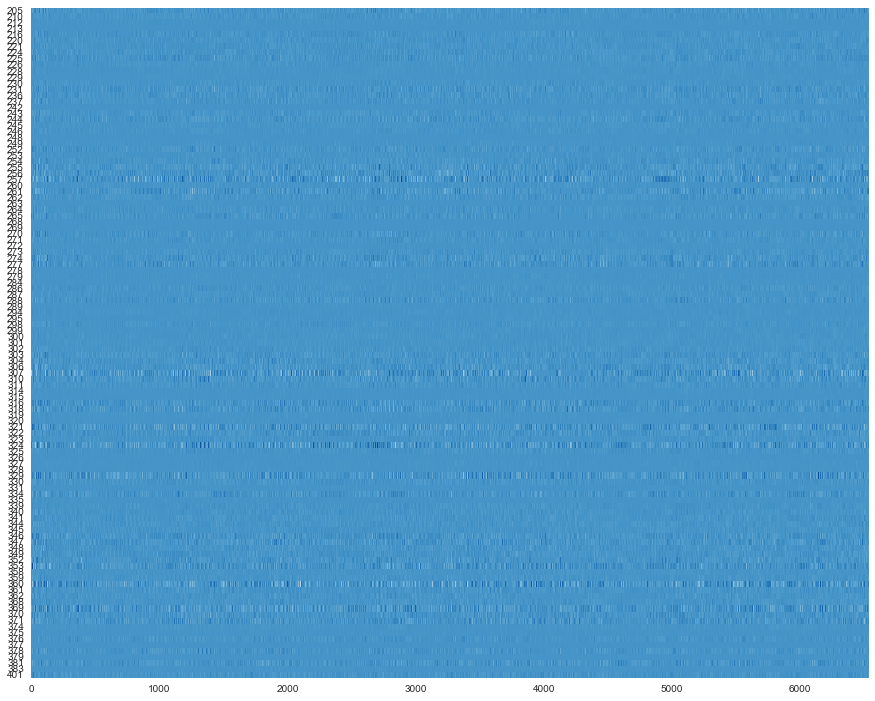

In [189]:
fig, ax = plt.subplots(1,1, figsize=(15,12))
ax.imshow(beta_mat, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
ax.set_yticks(range(len(pids)))
ax.set_yticklabels(pids)
ax.grid(False)
# plt.title("Selected Variables $> 2\sigma$ at $C=100$")
# avg_row_count = /np.mean((var_ind != 0).sum(1))
# ax.set_xlabel('Average nonzero count per row %2.4f' % avg_row_count)
print ''

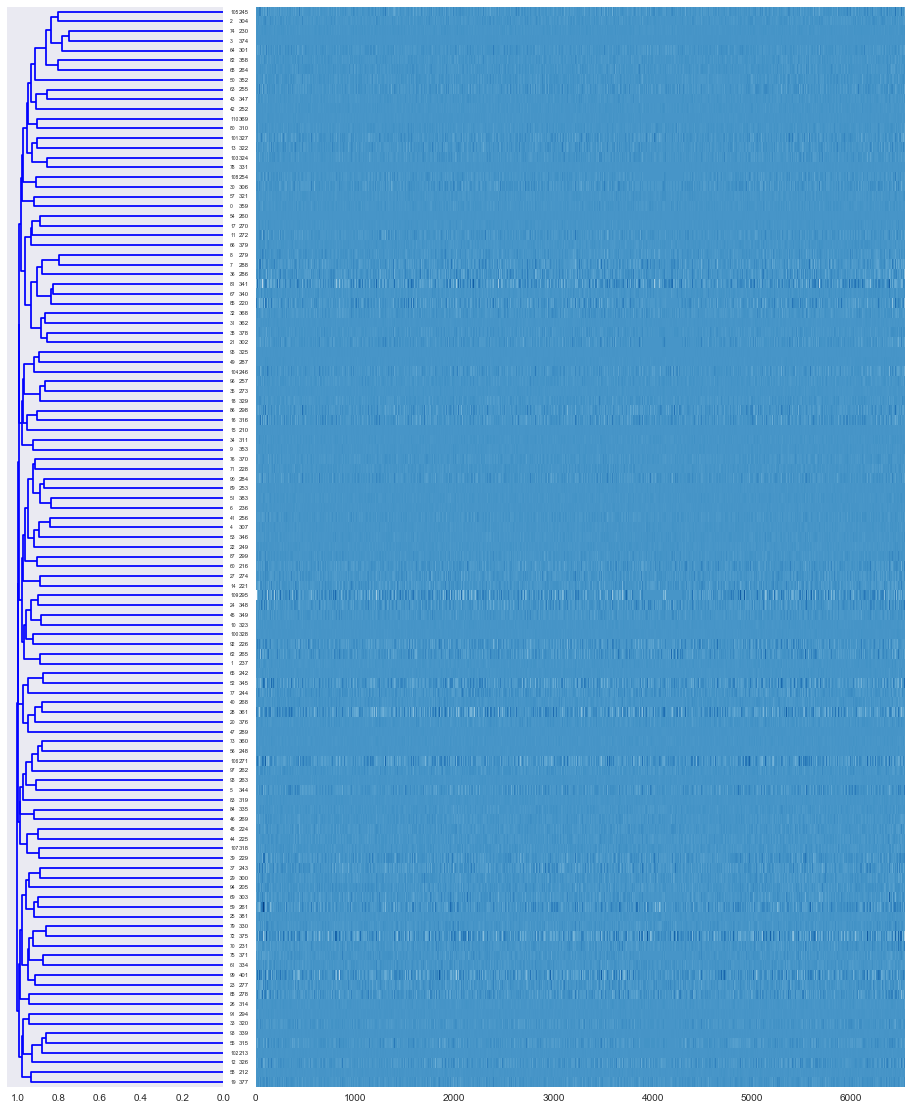

In [190]:
# dendrogram ax
fig = plt.figure(figsize=(15,15))
axd = fig.add_axes([0.09,0.1,0.2,1])
# var_ind, pids = select_stable(4)
links = linkage(beta_mat, method='average', metric='cosine')
dend = dendrogram(links, orientation='left')
axd.grid(False)
# axd.set_xticks([])
# axd.set_yticks([])

# matrix ax
axm = fig.add_axes([0.32,0.1,0.6,1])
var_ind = beta_mat[dend['leaves'],:]
axm.imshow(beta_mat, interpolation='nearest', aspect='auto', cmap=plt.cm.Blues)
axm.set_yticks(range(len(pids)))
pids = np.array(pids)[dend['leaves']]
axm.set_yticklabels(pids, fontsize=6)
axm.grid(False)
# axm.set_yticks(pids)
print

In [ ]:
### CUSTOM MPLD3 CLASS FOR VISUALIZING STABILITY PATHS ###
class HighlightLines(mpld3.plugins.PluginBase):
    """A plugin to highlight lines on hover"""

    JAVASCRIPT = """
    mpld3.register_plugin("linehighlight", LineHighlightPlugin);
    LineHighlightPlugin.prototype = Object.create(mpld3.Plugin.prototype);
    LineHighlightPlugin.prototype.constructor = LineHighlightPlugin;
    LineHighlightPlugin.prototype.requiredProps = ["line_ids"];
    LineHighlightPlugin.prototype.defaultProps = {alpha_bg:0.1, alpha_fg:1.0, 
                                                  bg_color:"#000000", fg_color:"#00FF00"};
    function LineHighlightPlugin(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    LineHighlightPlugin.prototype.draw = function(){
      for(var i=0; i<this.props.line_ids.length; i++){
         var obj = mpld3.get_element(this.props.line_ids[i], this.fig),
             alpha_fg = this.props.alpha_fg;
             alpha_bg = this.props.alpha_bg;
             bg_color = this.props.bg_color;
             fg_color = this.props.fg_color;
         obj.elements()
             .on("mouseover", function(d, i){
                            d3.select(this).transition().duration(50)
                              .style("stroke-opacity", alpha_fg)
                              .style("stroke-color", fg_color); })
             .on("mouseout", function(d, i){
                            d3.select(this).transition().duration(200)
                              .style("stroke-opacity", alpha_bg)
                              .style("stroke-color", bg_color); });
      }
    };
    """

    def __init__(self, lines):
        self.lines = lines
        self.dict_ = {"type": "linehighlight",
                      "line_ids": [mpld3.utils.get_id(line) for line in lines],
                      "alpha_bg": lines[0].get_alpha(),
                      "alpha_fg": 1.0,
                      "bg_color": lines[0].get_color(),
                      "fg_color":"#00FF00"}